## Machine Learning Final Project

### Prepared by Group 11
###  Group Members: Ivy Zhang, Mrimon “Nemo” Guha, Tiantong "Victor" Mao

### Table of Contents
- 1. Introduction
- 2. Dataset Description
- 3. Visual data analysis
- 4. Analysis using Regression

#### 1. Introduction:

Airbnbs are one of the most popular travelling booking apps/sites used by people all over the world. Travel agencies want to understand the availability and the pricing scheme of Airbnbs in Seattle and our analysis is crucial to finding the relationship across different variables such as number of rooms, type of rooms, reviews, host details


#####  2. Dataset Description

The data obtained from Kaggle contains property listings for Airbnbs in Seattle and some of their key metrics such as the type of property, number of bedrooms, price, neighborhood, review scores based on different criteria.
       

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import warnings
warnings.filterwarnings('ignore')

#### 3. Exploratory Data Analysis

In [2]:
#Importing the data
df_calendar = pd.read_csv("calendar.csv")
df_listings = pd.read_csv("listings.csv")
df_reviews = pd.read_csv("reviews.csv")

In [3]:
#Checking the dimensions in the dataset
for dataframe in [df_calendar, df_listings, df_reviews]:
    display(dataframe.shape)

# We will only use df_listings primarily since it stores the details of every house listings

(1393570, 4)

(3818, 92)

(84849, 6)

We have 3,818 house listings' data.  

In [4]:
#Displaying the list of the columns in the dataset
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

**Note:** 

Based on the description of the dataset from the source, it's largely cleaned. However, we realized every listings on Airbnb is different. Listing's performance highly depends on the host's decisions. Some hosts want their houses to generate as much profit as possible, while some may not care about the rent that much, and others may only lease their houses half the time a year. To address this issue, we want to only analyze those listings that have some deals with certain user reviews, and ignore those listings that seem to be sleeping. 

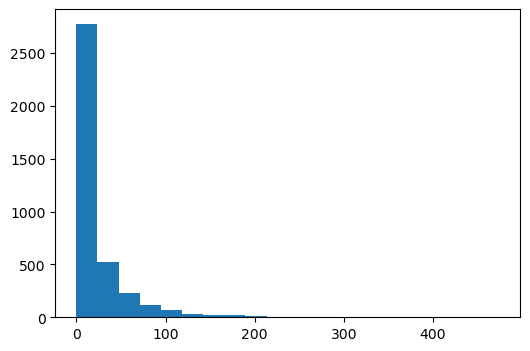

count    3818.000000
mean       22.223415
std        37.730892
min         0.000000
25%         2.000000
50%         9.000000
75%        26.000000
max       474.000000
Name: number_of_reviews, dtype: float64

In [5]:
# Plot a histogram for the number of reviews
plt.figure(figsize= (6,4))
plt.hist(df_listings.number_of_reviews, bins=20, label=True)
plt.show()

# Get more information on the number of reviews
display(df_listings.number_of_reviews.describe())

In [6]:
#Drop the bottom 25% listings, which has not more than 2 reviews. Consider these are sleeping listings
df_listings_filtered = df_listings[df_listings['number_of_reviews'] >= 2]

# How many listings we have in the filtered dataset
print("The number of listings that have at least 10 review number is: ", len(df_listings_filtered))

# Make sure we have no null values for the rating column
display(df_listings_filtered['review_scores_rating'].isna().any())

The number of listings that have at least 10 review number is:  2881


False

#### Addressing missing values. 

In [7]:
# Selct the features relevant to the property as candidate regressors
features_property = ['summary','space','description','neighborhood_overview','notes','transit',
                     'street','neighbourhood','zipcode','latitude','longitude','is_location_exact',
                     'property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type',
                     'amenities','square_feet','price','weekly_price','security_deposit','cleaning_fee',
                     'guests_included','extra_people','minimum_nights','maximum_nights']

# Check the number of null values for features that relate to the property
for feature in features_property:
    if df_listings_filtered[feature].isna().any(): 
        print('Feature name: "', feature, df_listings_filtered[feature].dtype, '". How many null values: ', 
            sum(df_listings_filtered[feature].isna()), 'out of', len(df_listings_filtered))
    else: 
        print('Feature name: "', feature, df_listings_filtered[feature].dtype, '" No missing values')

Feature name: " summary object ". How many null values:  159 out of 2881
Feature name: " space object ". How many null values:  256 out of 2881
Feature name: " description object " No missing values
Feature name: " neighborhood_overview object ". How many null values:  638 out of 2881
Feature name: " notes object ". How many null values:  1018 out of 2881
Feature name: " transit object ". How many null values:  543 out of 2881
Feature name: " street object " No missing values
Feature name: " neighbourhood object ". How many null values:  259 out of 2881
Feature name: " zipcode object ". How many null values:  5 out of 2881
Feature name: " latitude float64 " No missing values
Feature name: " longitude float64 " No missing values
Feature name: " is_location_exact object " No missing values
Feature name: " property_type object " No missing values
Feature name: " room_type object " No missing values
Feature name: " accommodates int64 " No missing values
Feature name: " bathrooms float64 ".

In [8]:
# Transform the longitude and lattitude features into the distance from that listing to a reference of interest
# In this case, we choose the distance between property and the Space Needle
# Use the Haversian Function to calculate the distance
def haversine(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula 
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of Earth in kilometers.
    return c * r

# Coordinates of the Space Needle
space_needle_lat, space_needle_lon = 47.620422, -122.349358

# Calculate the distance for each property in the DataFrame
df_listings_filtered['distance_to_space_needle'] = df_listings_filtered.apply(
    lambda row: haversine(row['latitude'], row['longitude'], space_needle_lat, space_needle_lon),
    axis=1
)

# See the distance 
display(df_listings_filtered['distance_to_space_needle'].head(10))

0     2.397768
1     2.411994
2     1.828845
4     2.220565
5     1.688299
6     2.302184
7     2.959735
8     1.457321
9     2.308346
10    1.808655
Name: distance_to_space_needle, dtype: float64

In [9]:
#Fixing any anomalous zipcodes
df_listings_filtered.zipcode[df_listings_filtered.zipcode=="99\n98122"] = 98122

In [10]:
#Convert price features to numeric data
price_features = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
for feature in price_features:
    df_listings_filtered[feature] = df_listings_filtered[feature].replace('[\$,]', '', regex=True).astype(float)
    #display(df_listings_filtered[feature].head())

# Fill missing values in 'weekly_price' with 'price' * 7 (say default weekly price is daily price*7)
df_listings_filtered['weekly_price'] = df_listings_filtered.apply(lambda row: row['price'] * 7 if pd.isnull(row['weekly_price']) else row['weekly_price'], axis=1)
# Fill missing values in 'monthly_price' with 'price' * 30 (say default monthly price is daily price*7)
df_listings_filtered['monthly_price'] = df_listings_filtered.apply(lambda row: row['price'] * 30 if pd.isnull(row['monthly_price']) else row['monthly_price'], axis=1)

# Fill missing values in 'security_deposit', 'cleaning_fee', 'extra_people' with 0
for column in ['security_deposit', 'cleaning_fee', 'extra_people']:
    df_listings_filtered[column] = df_listings_filtered[column].fillna(0)

# Check for any additional missing values in price features
df_listings_filtered[price_features].isna().any()

price               False
weekly_price        False
monthly_price       False
security_deposit    False
cleaning_fee        False
extra_people        False
dtype: bool

In [11]:
# Now create a new dataframe for regression with property features
df_X = df_listings_filtered[features_property]
df_X['distance_to_space_needle'] = df_listings_filtered['distance_to_space_needle']

In [12]:
# Unimportant features to drop
feaures_to_drop = ['summary', 'description', 'latitude', 'longitude', 'amenities', 'street', 'neighborhood_overview', 'notes', 'transit', 'space']
df_X.drop(feaures_to_drop,axis=1,inplace=True)

# Drop column square_feet for containing too many NA values (97.5%)
df_X.square_feet.isna().mean()
df_X.drop("square_feet",axis=1,inplace=True)

In [13]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2881 entries, 0 to 3814
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   neighbourhood             2622 non-null   object 
 1   zipcode                   2876 non-null   object 
 2   is_location_exact         2881 non-null   object 
 3   property_type             2881 non-null   object 
 4   room_type                 2881 non-null   object 
 5   accommodates              2881 non-null   int64  
 6   bathrooms                 2870 non-null   float64
 7   bedrooms                  2877 non-null   float64
 8   beds                      2881 non-null   float64
 9   bed_type                  2881 non-null   object 
 10  price                     2881 non-null   float64
 11  weekly_price              2881 non-null   float64
 12  security_deposit          2881 non-null   float64
 13  cleaning_fee              2881 non-null   float64
 14  guests_i

In [14]:
# Categorical features 
object_features = df_X.select_dtypes(include=['object']).columns

# Filling missing values with an empty string in all object columns
df_X[object_features] = df_X[object_features].fillna('')

# One-hot encoding categorical variables
df_X = pd.get_dummies(df_X, columns = object_features, drop_first=True)

In [15]:
# Selecting only the columns that are numeric
numeric_features = df_X.select_dtypes(include=[np.number]).columns

# Filling NaN values with the median in all numeric columns
for col in numeric_features:
    df_X[col] = df_X[col].fillna(df_X[col].median())

In [16]:
# Check for any missing values
df_X.isna().any().any()

False

In [17]:
df_X.head()

accommodates  bathrooms  bedrooms  beds  price  weekly_price  \
0             4        1.0       1.0   1.0   85.0         595.0   
1             4        1.0       1.0   1.0  150.0        1000.0   
2            11        4.5       5.0   7.0  975.0        6825.0   
4             6        2.0       3.0   3.0  450.0        3150.0   
5             2        1.0       1.0   1.0  120.0         800.0   

   security_deposit  cleaning_fee  guests_included  extra_people  ...  \
0               0.0           0.0                2           5.0  ...   
1             100.0          40.0                1           0.0  ...   
2            1000.0         300.0               10          25.0  ...   
4             700.0         125.0                6          15.0  ...   
5               0.0          40.0                1          30.0  ...   

   property_type_Tent  property_type_Townhouse  property_type_Treehouse  \
0                   0                        0                        0   
1                   0                        0                        0   
2                   0                        0                        0   
4                   0                        0                        0   
5                   0                        0                        0   

   property_type_Yurt  room_type_Private room  room_type_Shared room  \
0                   0                       0                      0   
1                   0                       0                      0   
2                   0                       0                      0   
4                   0                       0                      0   
5                   0                       1                      0   

   bed_type_Couch  bed_type_Futon  bed_type_Pull-out Sofa  bed_type_Real Bed  
0               0               0                       0                  1  
1               0               0                       0                  1  
2               0               0                       0                  1  
4               0               0                       0                  1  
5               0               0                       0                  1  

[5 rows x 141 columns]

Response variable

In [18]:
# We want to use the availability as a booking rate metric
# The higher this value relative to its respective timeframe (30, 60, 90, and 365 days), the more popular is the house listed since it's 
df_Y = df_listings_filtered[['availability_30', 'availability_60', 'availability_90', 'availability_365']]
df_Y.head()

availability_30  availability_60  availability_90  availability_365
0               14               41               71               346
1               13               13               16               291
2                1                6               17               220
4               30               60               90               365
5                0                0               27               302

In [19]:
# We want to use the availability as a booking rate metric
# The higher this value relative to its respective timeframe (30, 60, 90, and 365 days), the more popular is the house listed since it's 
df_Y2 = df_listings_filtered[['price', 'weekly_price', 'monthly_price']]
df_Y2.head()

price  weekly_price  monthly_price
0   85.0         595.0         2550.0
1  150.0        1000.0         3000.0
2  975.0        6825.0        29250.0
4  450.0        3150.0        13500.0
5  120.0         800.0         3600.0

#### Now our data is ready for regression. Try fit 4 regression models for availability_30, availability_60, availability_90, availability_365 and compare the difference. 

1. To remove the unqualified housing in then dataset: <20 reviews. 
2. Split the remaining houses into two groups: one group with above average rating, one group below average rating. See the difference in for example, average prices / average number of beds / number of rooms for these two groups.
3. Then we do the regression on ratings. Different regressions: Lasso, Ridge, Tree, Random Forest, Neural Network. Cross validation to determine the optimal paramenter. Identify the important features in each of these models. 
Victor: Prepare the data
Ivy: EDA
Nemo: Linear models

#### 4.Visual exploratory data analysis

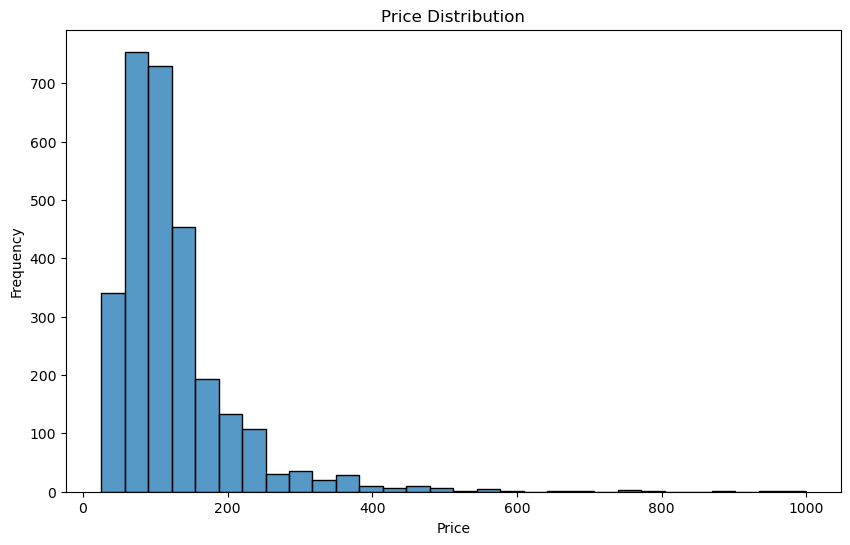

In [20]:
#Plotting a histogram of price
plt.figure(figsize=(10, 6))
sns.histplot(df_listings_filtered['price'], bins=30)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

**Inference:**

- Most of the Airbnb listings have prices withing 200 USD. 
- Very few Airbnb rooms have prices that are higher than 400 USD and even fewer higher than 800 USD

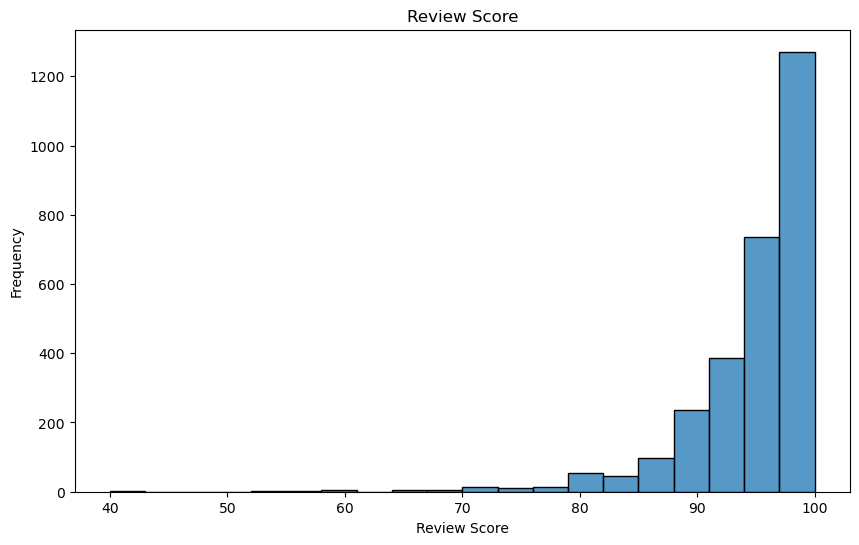

In [21]:
# Review Score Histogram Distribution (e.g., review_scores_rating)
plt.figure(figsize=(10, 6))
sns.histplot(df_listings_filtered['review_scores_rating'].dropna(), bins=20)
plt.title('Review Score')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.show()

**Inference:**

- Most of the Airbnb listings have review scores over 90 and the highest frequency is for reviews with score over 100
- This shows that the listings have a very high scores on an average and are well maintained. 

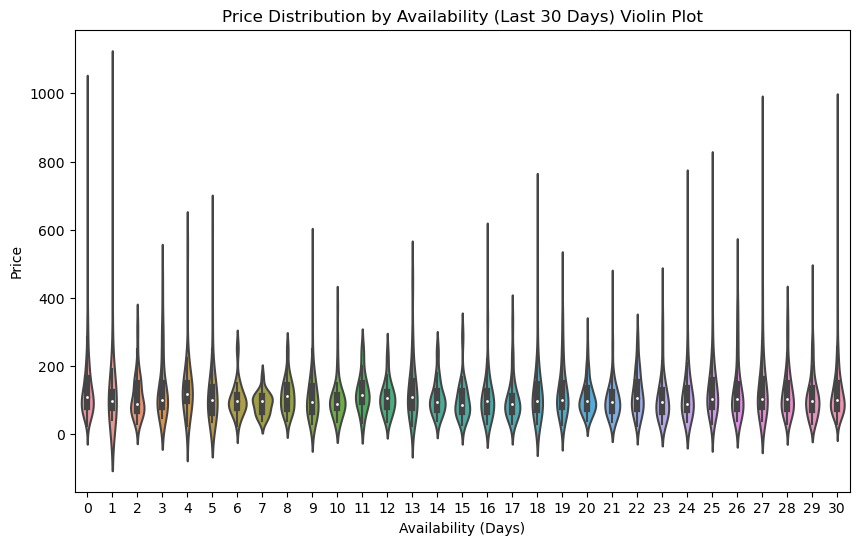

In [22]:
#Violin Plot of availability and price
plt.figure(figsize=(10, 6))
sns.violinplot(x='availability_30', y='price', data=df_listings_filtered)
plt.title('Price Distribution by Availability (Last 30 Days) Violin Plot')
plt.xlabel('Availability (Days)')
plt.ylabel('Price')
plt.show()

**Inference:**

- This plot helps us visualize the availability along with the prices for the listings over the course of the next 30 days
- Listings that are available within the next 15 days days have an average price of 200-600 USD

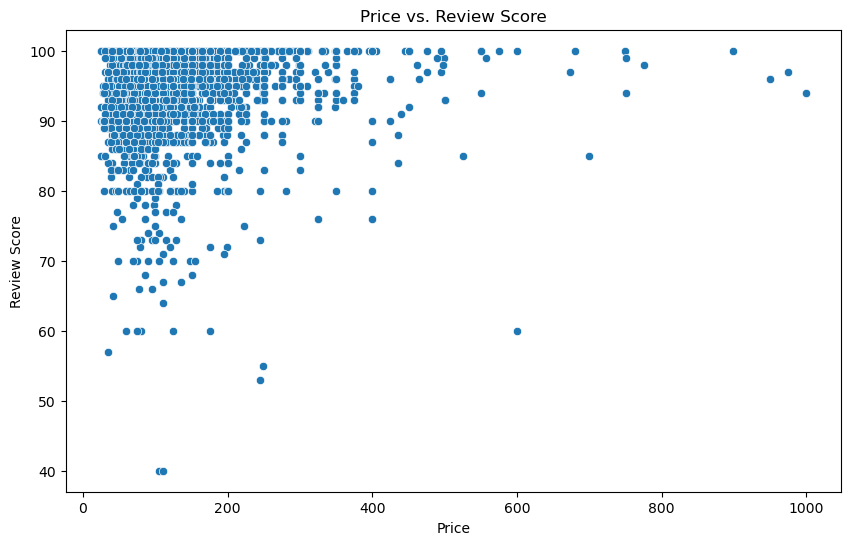

In [23]:
#Price and review score relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='review_scores_rating', data=df_listings_filtered)
plt.title('Price vs. Review Score')
plt.xlabel('Price')
plt.ylabel('Review Score')
plt.show()


**Inference:**

- Most of the Airbnb listings have prices withing 200 USD with scores above 80. 
- Higher priced listings have fewer reviews but most of them within 80-100 score range

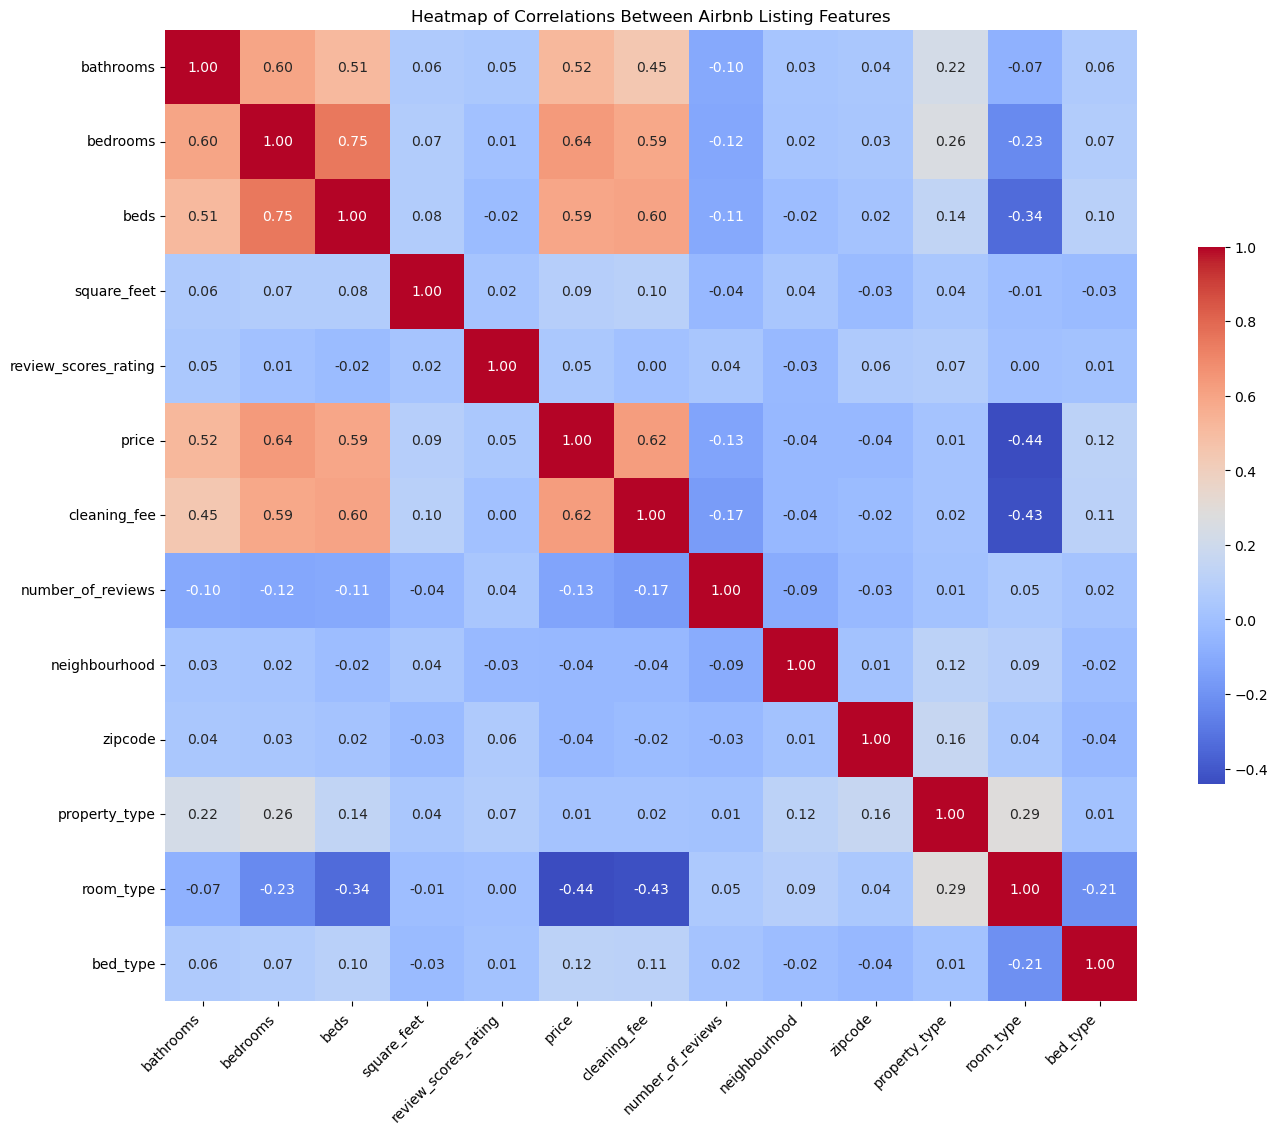

In [24]:

# Convert price and cleaning fee to numerical values
df_listings_filtered['price'] = df_listings_filtered['price'].replace('[\$,]', '', regex=True).astype(float)
df_listings_filtered['cleaning_fee'] = df_listings_filtered['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)

# Fill missing numeric values with the mean
numeric_columns = ['bathrooms', 'bedrooms', 'beds', 'square_feet', 'review_scores_rating', 'price', 'cleaning_fee', 'number_of_reviews']
df_listings_filtered[numeric_columns] = df_listings_filtered[numeric_columns].fillna(df_listings_filtered[numeric_columns].mean())

# Encode categorical variables
categorical_columns = ['neighbourhood', 'zipcode', 'property_type', 'room_type', 'bed_type']
for col in categorical_columns:
    df_listings_filtered[col] = LabelEncoder().fit_transform(df_listings_filtered[col].astype(str))

# Select relevant columns for correlation analysis
columns_of_interest = numeric_columns + categorical_columns
processed_data = df_listings_filtered[columns_of_interest]

# Calculate correlation matrix
correlation_matrix = processed_data.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})
plt.title('Heatmap of Correlations Between Airbnb Listing Features')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

##### Inference:
It is obvious that the price correlated with number of bed, bedrooms, bathrooms, and cleanning fees. 

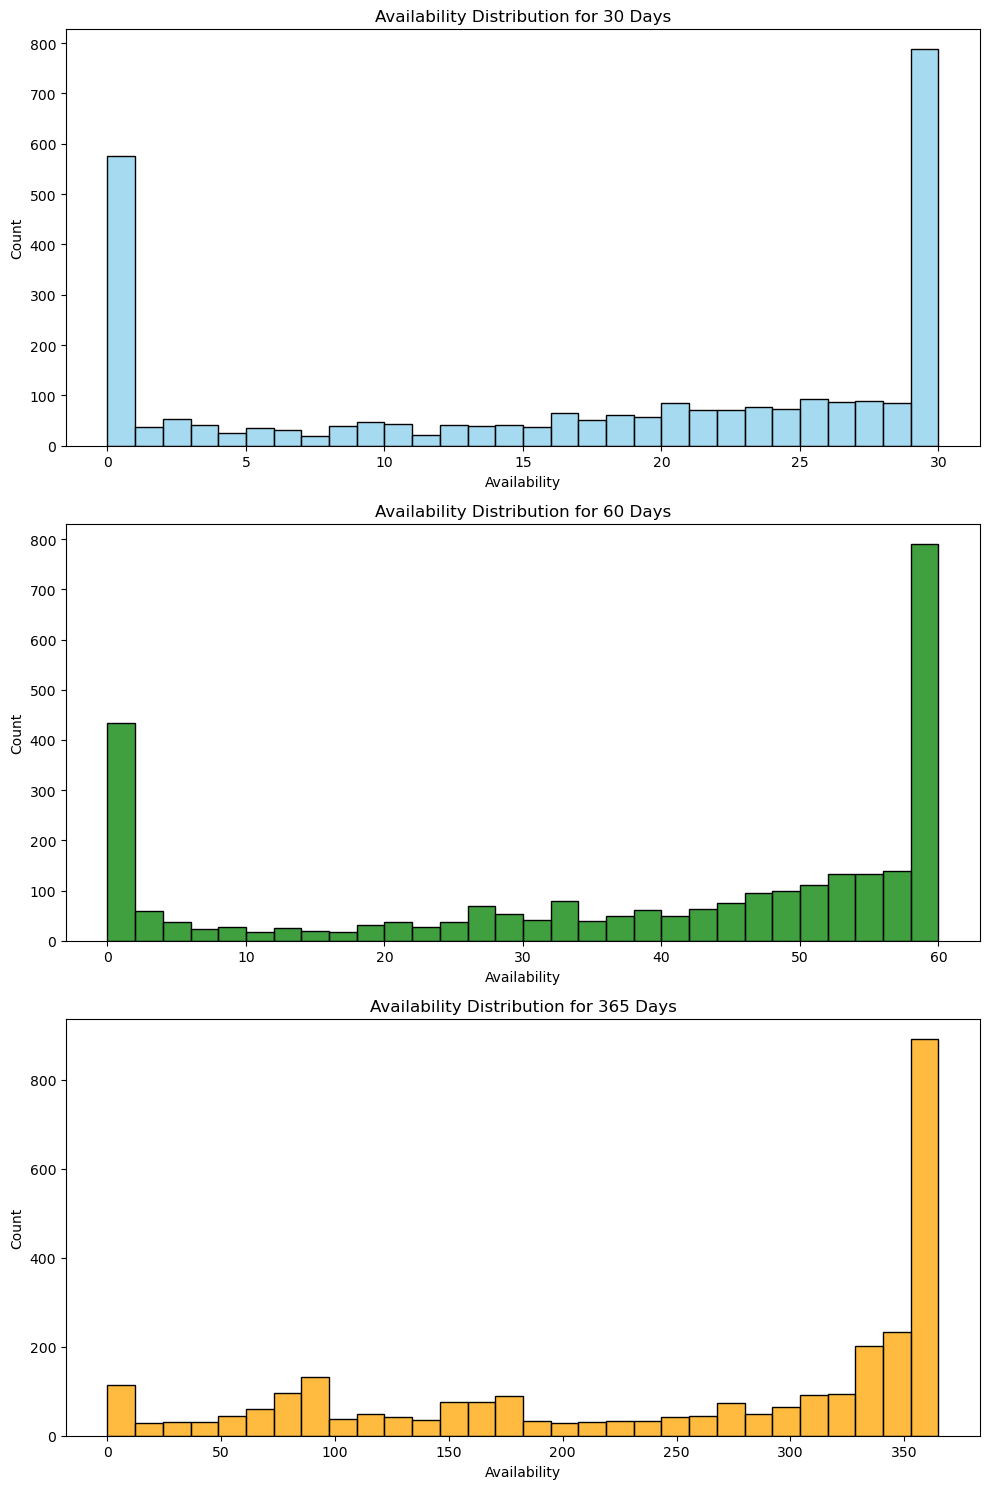

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot the distribution of availability for 30 days
sns.histplot(df_listings_filtered['availability_30'], bins=30, ax=axes[0], kde=False, color='skyblue')
axes[0].set_title('Availability Distribution for 30 Days')
axes[0].set_xlabel('Availability')
axes[0].set_ylabel('Count')

# Plot the distribution of availability for 60 days
sns.histplot(df_listings_filtered['availability_60'], bins=30, ax=axes[1], kde=False, color='green')
axes[1].set_title('Availability Distribution for 60 Days')
axes[1].set_xlabel('Availability')
axes[1].set_ylabel('Count')

# Plot the distribution of availability for 365 days
sns.histplot(df_listings_filtered['availability_365'], bins=30, ax=axes[2], kde=False, color='orange')
axes[2].set_title('Availability Distribution for 365 Days')
axes[2].set_xlabel('Availability')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

**INFERENCE**-The peaks at high availability for all three time frames could suggest that a substantial number of listings are either new (not yet booked) or used infrequently for rentals. The peaks at low availability could also be due to listings that are in high demand, thus often booked, or alternatively, hosts might be living in their properties most of the time and only making them available when they are away.

### 5. Analysis using Regression

### Model Number- 1 for checking availability for 30 days

In [26]:
#Performing linear regression
Y = df_listings_filtered['availability_30']

X = sm.add_constant(df_X) 
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        availability_30   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.480
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           5.03e-18
Time:                        19:27:16   Log-Likelihood:                -11005.
No. Observations:                2881   AIC:                         2.229e+04
Df Residuals:                    2740   BIC:                         2.313e+04
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

**Inference:**

- R-squared value is 0.112 which means that 11.2% of the variation in the model is explained by the variables. This is not a very high R-square value
- Some of the significant variables are: Accommodates, Bathrooms, Bedrooms, Price, Weekly Price, Cleaning Fee ,Guests Included based on p-values
- For each unit rise in 'accommodates', there is an estimated increase of 0.5690 in availability_30.
- For each unit increase in 'bathrooms', there is an estimated decrease of 1.1690 in availability_30.
- For each unit increase in 'bedrooms', there is an estimated decrease of 2.5434 in availability_30.
- As the price increases, availability_30 decreases by 0.0314 units.


In [27]:
from sklearn.metrics import mean_squared_error, r2_score

#Splitting the data with test size of 30% and train size of 70%
Y2_split=Y
X2_split=X

train_x2, test_x2, train_y2, test_y2 = train_test_split(X2_split, Y2_split, test_size = 0.3, random_state = 42)
X2_train_constant = sm.add_constant(train_x2)
X2_test_constant = sm.add_constant(test_x2)

#Train data for model creation
model_split = sm.OLS(train_y2, X2_train_constant).fit()

print(model_split.summary())

# Testing model using test data 
predictions = model_split.predict(X2_test_constant)

mse_split = mean_squared_error(test_y2, predictions)
r2_split = r2_score(test_y2, predictions)
print("\n-------------------------------------------------")
print("Mean squared error is",mse_split)
print("R2 value is",r2_split)

                            OLS Regression Results                            
Dep. Variable:        availability_30   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1.995
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           5.25e-10
Time:                        19:27:16   Log-Likelihood:                -7702.5
No. Observations:                2016   AIC:                         1.568e+04
Df Residuals:                    1880   BIC:                         1.644e+04
Df Model:                         135                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

**Inference:**

- R-squared value is 0.125 which means that 12.5% of the variation in the model is explained by the variables. This is not a very high R-square value
- Some of the significant variables are: Bedrooms, Price, Weekly_price , Cleaning_fee
- Each additional bedroom reduces the "avaliability_30" by 2.68 units. A price increase of 1 unit decreases the avaliability_30 by 0.0351 units, while a weekly price hike of 1 unit increases it by 0.0066 units. Similarly, a rise of 1 unit in cleaning fee leads to an increase of about 0.0231 units in avaliability_30.

In [28]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.preprocessing import StandardScaler
# Standardising our scales as Lasso regularisation is sensitive to it
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x2)

# Transforming new data using training data's mean and standard deviation
test_x_scaled = scaler.transform(test_x2) 
alphas = np.logspace(-6, 6, 10)


In [29]:
#k-fold cross validation with k=5
k = 5
n = len(train_y2)

#Data shuffling
indices = np.arange(n)
np.random.shuffle(indices)

In [30]:
#Scaling the data for cross validation
X_cv = train_x_scaled[indices]
y_cv = train_y2.iloc[indices]

In [31]:
#Manually k-fold cross validation
avg_rmse=[]
for alpha in alphas:
    rmse_list = []
    
    #Manual k-fold splitting
    for fold in range(k):
        #Size of each fold
        fold_size = n // k
        
        
        start, end = fold * fold_size, (fold + 1) * fold_size
        
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        
        X_train, X_test = X_cv[train_indices], X_cv[test_indices]
        y_train, y_test = y_cv.iloc[train_indices], y_cv.iloc[test_indices]
        
        lasso = Lasso(alpha=alpha)
        
        lasso.fit(X_train, y_train)
        
        y_pred = lasso.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        rmse_list.append(rmse)
        
    avg_rmse.append(np.mean(rmse_list))

#Best alpha value for regularization
best_alpha = alphas[np.argmin(avg_rmse)]
print(f"Best alpha: {best_alpha}")

Best alpha: 0.21544346900318823


In [32]:
#Fitting the lasso regression using lambda=2154
lasso = Lasso(alpha=0.21544346900318823)
lasso.fit(train_x_scaled, train_y2)

# Evaluate the in-sample performance
pred_y = lasso.predict(train_x_scaled)

mse = mean_squared_error(train_y2, pred_y)
r2 = r2_score(train_y2, pred_y)
print("In sample MSE:", mse)
print("In sample R^2:", r2)

# Evaluate the out-of-sample performance
pred_y = lasso.predict(test_x_scaled)

mse = mean_squared_error(test_y2, pred_y)
r2 = r2_score(test_y2, pred_y)
print("Out of sample MSE:", mse)
print("Out of sample R^2:", r2)

In sample MSE: 127.84293642641678
In sample R^2: 0.08295542008957502
Out of sample MSE: 126.71871056144383
Out of sample R^2: 0.03911739393336788


**Inference:**

- The out of sample R2 is not too high so model might not be suitable for prediction out of samples

In [33]:
####Ridge
from sklearn.linear_model import Ridge

# Specify alpha values for Ridge regression
alphas = np.logspace(-6, 6, 10)

# k-fold cross validation with k=5
k = 5
n = len(train_y2)

# Data shuffling
indices = np.arange(n)
np.random.shuffle(indices)
X_cv = train_x_scaled[indices]
y_cv = train_y2.iloc[indices]

# Manually k-fold cross validation
avg_rmse = []
for alpha in alphas:
    rmse_list = []
    
    # Manual k-fold splitting
    for fold in range(k):
        # Size of each fold
        fold_size = n // k
        
        start, end = fold * fold_size, (fold + 1) * fold_size
        
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        
        X_train, X_test = X_cv[train_indices], X_cv[test_indices]
        y_train, y_test = y_cv.iloc[train_indices], y_cv.iloc[test_indices]
        
        ridge = Ridge(alpha=alpha)  # Use Ridge instead of Lasso
        
        ridge.fit(X_train, y_train)
        
        y_pred = ridge.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        rmse_list.append(rmse)
        
    avg_rmse.append(np.mean(rmse_list))

# Best alpha value for Ridge
best_alpha = alphas[np.argmin(avg_rmse)]
print(f"Best alpha for Ridge: {best_alpha}")

# Fitting the Ridge regression using the best alpha
ridge = Ridge(alpha=best_alpha)
ridge.fit(train_x_scaled, train_y2)

# Evaluate the in-sample performance
pred_y = ridge.predict(train_x_scaled)

mse = mean_squared_error(train_y2, pred_y)
r2 = r2_score(train_y2, pred_y)
print("In sample MSE for Ridge:", mse)
print("In sample R^2 for Ridge:", r2)

# Transforming new data using training data's mean and standard deviation
test_x_scaled = scaler.transform(test_x2)

# Evaluate the out-of-sample performance
pred_y = ridge.predict(test_x_scaled)

mse = mean_squared_error(test_y2, pred_y)
r2 = r2_score(test_y2, pred_y)
print("Out of sample MSE for Ridge:", mse)
print("Out of sample R^2 for Ridge:", r2)


Best alpha for Ridge: 2154.434690031878
In sample MSE for Ridge: 128.7057620932807
In sample R^2 for Ridge: 0.07676618802620983
Out of sample MSE for Ridge: 129.68823253643095
Out of sample R^2 for Ridge: 0.01660010346019658


**Inference:**

- R-squared value is 7.6% and 1.6% for in sample R2 and out of sample R2. This suggests that this model is not suitable for prediction


### Model Number- 2 for checking availability for 60 days

In [34]:
Y = df_listings_filtered['availability_60']

X = sm.add_constant(df_X) 
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        availability_60   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     2.671
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           3.30e-21
Time:                        19:27:21   Log-Likelihood:                -12836.
No. Observations:                2881   AIC:                         2.595e+04
Df Residuals:                    2740   BIC:                         2.680e+04
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

**Inference:**


- R-squared value is 0.12, which means that 12.0% of the variation in the model is explained by the variables. This is not a very high R-squared value.
- Some of the significant variables are: Accommodates, Bathrooms, Bedrooms, Price, Weekly Price, Cleaning Fee, and Guests Included based on p-values.
- For each unit rise in 'accommodates', there is an estimated increase of 1.0879 in availability_30. For each unit increase in 'bathrooms', there is an estimated decrease of 2.55 in availability_30. For each unit increase in 'bedrooms', there is an estimated decrease of 5.13 in availability_30. As the price increases, availability_30 decreases by 0.0589 units.

In [35]:
from sklearn.metrics import mean_squared_error, r2_score

#Splitting the data with test size of 30% and train size of 70%
Y2_split=Y
X2_split=X

train_x2, test_x2, train_y2, test_y2 = train_test_split(X2_split, Y2_split, test_size = 0.3, random_state = 42)
X2_train_constant = sm.add_constant(train_x2)
X2_test_constant = sm.add_constant(test_x2)

#Train data for model creation
model_split = sm.OLS(train_y2, X2_train_constant).fit()

print(model_split.summary())

# Testing model using test data 
predictions = model_split.predict(X2_test_constant)

mse_split = mean_squared_error(test_y2, predictions)
r2_split = r2_score(test_y2, predictions)
print("\n-------------------------------------------------")
print("Mean squared error is",mse_split)
print("R2 value is",r2_split)

                            OLS Regression Results                            
Dep. Variable:        availability_60   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     2.108
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           1.60e-11
Time:                        19:27:21   Log-Likelihood:                -8992.7
No. Observations:                2016   AIC:                         1.826e+04
Df Residuals:                    1880   BIC:                         1.902e+04
Df Model:                         135                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

**Inference:**

- R-squared value is 0.131, which means that 13.1% of the variation in the model is explained by the variables. This is a relatively low R-squared value.
- Some of the significant variables are: Bedrooms, Price, Weekly Price, Cleaning Fee, Guests Included, Neighbourhoods (Broadview, South Lake Union, Yesler Terrace), Room Types (Private room, Shared room) based on p-values.
- For each unit increase in 'bedrooms', there is an estimated decrease of 5.1331 in availability_60.
- As the price increases, availability_60 decreases by 0.0632 units.


In [36]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.preprocessing import StandardScaler
# Standardising our scales as Lasso regularisation is sensitive to it
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x2)

# Transforming new data using training data's mean and standard deviation
test_x_scaled = scaler.transform(test_x2) 
alphas = np.logspace(-6, 6, 10)


In [37]:
#k-fold cross validation with k=5
k = 5
n = len(train_y2)

#Data shuffling
indices = np.arange(n)
np.random.shuffle(indices)

In [38]:
X_cv = train_x_scaled[indices]
y_cv = train_y2.iloc[indices]

In [39]:
#Manually k-fold cross validation
avg_rmse=[]
for alpha in alphas:
    rmse_list = []
    
    #Manual k-fold splitting
    for fold in range(k):
        #Size of each fold
        fold_size = n // k
        
        
        start, end = fold * fold_size, (fold + 1) * fold_size
        
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        
        X_train, X_test = X_cv[train_indices], X_cv[test_indices]
        y_train, y_test = y_cv.iloc[train_indices], y_cv.iloc[test_indices]
        
        lasso = Lasso(alpha=alpha)
        
        lasso.fit(X_train, y_train)
        
        y_pred = lasso.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        rmse_list.append(rmse)
        
    avg_rmse.append(np.mean(rmse_list))

#Best alpha value
best_alpha = alphas[np.argmin(avg_rmse)]
print(f"Best alpha: {best_alpha}")

Best alpha: 0.21544346900318823


In [40]:
#Fitting the lasso regression using lambda=2154
lasso = Lasso(alpha=0.21544346900318823)
lasso.fit(train_x_scaled, train_y2)

# Evaluate the in-sample performance
pred_y = lasso.predict(train_x_scaled)

mse = mean_squared_error(train_y2, pred_y)
r2 = r2_score(train_y2, pred_y)
print("In sample MSE:", mse)
print("In sample R^2:", r2)

# Evaluate the out-of-sample performance
pred_y = lasso.predict(test_x_scaled)

mse = mean_squared_error(test_y2, pred_y)
r2 = r2_score(test_y2, pred_y)
print("Out of sample MSE:", mse)
print("Out of sample R^2:", r2)

In sample MSE: 446.8138420315893
In sample R^2: 0.11508147642705724
Out of sample MSE: 451.19069848854616
Out of sample R^2: 0.03084356187951065


**Inference:**

- R-squared value is 0.115 which means that 11.5% of the variation in the model is explained by the variables. This is not a very high R-square value (for in sample R2)
- the out of sample R2 have a lower R2

In [41]:
####Ridge
from sklearn.linear_model import Ridge

# Specify alpha values for Ridge regression
alphas = np.logspace(-6, 6, 10)

# k-fold cross validation with k=5
k = 5
n = len(train_y2)

# Data shuffling
indices = np.arange(n)
np.random.shuffle(indices)
X_cv = train_x_scaled[indices]
y_cv = train_y2.iloc[indices]

# Manually k-fold cross validation
avg_rmse = []
for alpha in alphas:
    rmse_list = []
    
    # Manual k-fold splitting
    for fold in range(k):
        # Size of each fold
        fold_size = n // k
        
        start, end = fold * fold_size, (fold + 1) * fold_size
        
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        
        X_train, X_test = X_cv[train_indices], X_cv[test_indices]
        y_train, y_test = y_cv.iloc[train_indices], y_cv.iloc[test_indices]
        
        ridge = Ridge(alpha=alpha)  # Use Ridge instead of Lasso
        
        ridge.fit(X_train, y_train)
        
        y_pred = ridge.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        rmse_list.append(rmse)
        
    avg_rmse.append(np.mean(rmse_list))

# Best alpha value for Ridge
best_alpha = alphas[np.argmin(avg_rmse)]
print(f"Best alpha for Ridge: {best_alpha}")

# Fitting the Ridge regression using the best alpha
ridge = Ridge(alpha=best_alpha)
ridge.fit(train_x_scaled, train_y2)

# Evaluate the in-sample performance
pred_y = ridge.predict(train_x_scaled)

mse = mean_squared_error(train_y2, pred_y)
r2 = r2_score(train_y2, pred_y)
print("In sample MSE for Ridge:", mse)
print("In sample R^2 for Ridge:", r2)

# Transforming new data using training data's mean and standard deviation
test_x_scaled = scaler.transform(test_x2)

# Evaluate the out-of-sample performance
pred_y = ridge.predict(test_x_scaled)

mse = mean_squared_error(test_y2, pred_y)
r2 = r2_score(test_y2, pred_y)
print("Out of sample MSE for Ridge:", mse)
print("Out of sample R^2 for Ridge:", r2)


Best alpha for Ridge: 2154.434690031878
In sample MSE for Ridge: 462.8277078573971
In sample R^2 for Ridge: 0.08336588221261654
Out of sample MSE for Ridge: 456.45787111551783
Out of sample R^2 for Ridge: 0.019529688878090146


**Inference:**

- R-squared value is 0.08 which means that 8% of the variation in the model is explained by the variables. This is not a very high R-square value (for in sample R2)
- the out of sample R2 have a lower R2 i.e. 0.019

### Model Number- 3 for checking availability for 90 days

In [42]:
Y = df_listings_filtered['availability_90']

X = sm.add_constant(df_X) 
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        availability_90   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     2.743
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           1.94e-22
Time:                        19:27:25   Log-Likelihood:                -13886.
No. Observations:                2881   AIC:                         2.805e+04
Df Residuals:                    2740   BIC:                         2.890e+04
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

**Inference:**

- R-squared value of 0.123 indicates that approximately 12.3% of the variability in availability_90 can be explained by the independent variables in the model. This suggests a relatively low level of explanatory power.
- Some of the significant variables based on their p-values are: bedrooms, price, weekly price, cleaning fee, neighborhood, room types.
- For each additional bedroom, there is an estimated decrease of approximately 7.87 units in availability_90.
- As the price increases, availability_90 decreases by about 0.069 units.
- For each unit increase in weekly price, availability_90 increases by approximately 0.0133 units.
- An increase in the cleaning fee means an increase in availability_90 by around 0.0796 units.
- Some neighbourhoods suggest that they are statistically significant over the other
- Some rooom types such as private room shared room are significant

In [43]:
from sklearn.metrics import mean_squared_error, r2_score

#Splitting the data with test size of 30% and train size of 70%
Y2_split=Y
X2_split=X

train_x2, test_x2, train_y2, test_y2 = train_test_split(X2_split, Y2_split, test_size = 0.3, random_state = 42)
X2_train_constant = sm.add_constant(train_x2)
X2_test_constant = sm.add_constant(test_x2)

#Train data for model creation
model_split = sm.OLS(train_y2, X2_train_constant).fit()

print(model_split.summary())

# Testing model using test data 
predictions = model_split.predict(X2_test_constant)

mse_split = mean_squared_error(test_y2, predictions)
r2_split = r2_score(test_y2, predictions)
print("\n-------------------------------------------------")
print("Mean squared error is",mse_split)
print("R2 value is",r2_split)

                            OLS Regression Results                            
Dep. Variable:        availability_90   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     2.130
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           8.06e-12
Time:                        19:27:26   Log-Likelihood:                -9733.1
No. Observations:                2016   AIC:                         1.974e+04
Df Residuals:                    1880   BIC:                         2.050e+04
Df Model:                         135                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

**Inference:**

- R-squared value of 0.133 indicates that approx. 13.3% of the variability in availability_90 can be explained by the independent variables in the model. This suggests a relatively low level of explanatory power.
- Some of the significant variables based on their p-values are: bedrooms, price, weekly price, neighbourhoods, cleaning fee
- For each additional bedroom, there is an estimated decrease of approximately 7.68 units in availability_90.
- As the price increases, availability_90 decreases by about 0.077 units.
- For each unit increase in weekly price, availability_90 increases by approximately 0.014 units.
- An increase in the cleaning fee is associated with an increase in availability_90 by around 0.071 units.
- Some neighborhoods and room types have significant coefficients

In [44]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.preprocessing import StandardScaler
# Standardising our scales as Lasso regularisation is sensitive to it
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x2)

# Transforming new data using training data's mean and standard deviation
test_x_scaled = scaler.transform(test_x2) 
alphas = np.logspace(-6, 6, 10)

In [45]:
#k-fold cross validation with k=5
k = 5
n = len(train_y2)

#Data shuffling
indices = np.arange(n)
np.random.shuffle(indices)

In [46]:
X_cv = train_x_scaled[indices]
y_cv = train_y2.iloc[indices]

In [47]:
#Manually k-fold cross validation
avg_rmse=[]
for alpha in alphas:
    rmse_list = []
    
    #Manual k-fold splitting
    for fold in range(k):
        #Size of each fold
        fold_size = n // k
        
        
        start, end = fold * fold_size, (fold + 1) * fold_size
        
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        
        X_train, X_test = X_cv[train_indices], X_cv[test_indices]
        y_train, y_test = y_cv.iloc[train_indices], y_cv.iloc[test_indices]
        
        lasso = Lasso(alpha=alpha)
        
        lasso.fit(X_train, y_train)
        
        y_pred = lasso.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        rmse_list.append(rmse)
        
    avg_rmse.append(np.mean(rmse_list))

#Best alpha value
best_alpha = alphas[np.argmin(avg_rmse)]
print(f"Best alpha: {best_alpha}")

Best alpha: 0.21544346900318823


In [48]:
#Fitting the lasso regression using lambda=2154
lasso = Lasso(alpha=0.21544346900318823)
lasso.fit(train_x_scaled, train_y2)

# Evaluate the in-sample performance
pred_y = lasso.predict(train_x_scaled)

mse = mean_squared_error(train_y2, pred_y)
r2 = r2_score(train_y2, pred_y)
print("In sample MSE:", mse)
print("In sample R^2:", r2)

# Evaluate the out-of-sample performance
pred_y = lasso.predict(test_x_scaled)

mse = mean_squared_error(test_y2, pred_y)
r2 = r2_score(test_y2, pred_y)
print("Out of sample MSE:", mse)
print("Out of sample R^2:", r2)

In sample MSE: 924.6908840954833
In sample R^2: 0.12261713610770231
Out of sample MSE: 929.1680304096114
Out of sample R^2: 0.030547457382603227


Based on the in sample and out of sample R2, the R2 is 12.2% and 3% respectively. These are low scores and does not explain why we could use this for prediction of the data

In [49]:
####Ridge
from sklearn.linear_model import Ridge

# Specify alpha values for Ridge regression
alphas = np.logspace(-6, 6, 10)

# k-fold cross validation with k=5
k = 5
n = len(train_y2)

# Data shuffling
indices = np.arange(n)
np.random.shuffle(indices)
X_cv = train_x_scaled[indices]
y_cv = train_y2.iloc[indices]

# Manually k-fold cross validation
avg_rmse = []
for alpha in alphas:
    rmse_list = []
    
    # Manual k-fold splitting
    for fold in range(k):
        # Size of each fold
        fold_size = n // k
        
        start, end = fold * fold_size, (fold + 1) * fold_size
        
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        
        X_train, X_test = X_cv[train_indices], X_cv[test_indices]
        y_train, y_test = y_cv.iloc[train_indices], y_cv.iloc[test_indices]
        
        ridge = Ridge(alpha=alpha)  # Use Ridge instead of Lasso
        
        ridge.fit(X_train, y_train)
        
        y_pred = ridge.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        rmse_list.append(rmse)
        
    avg_rmse.append(np.mean(rmse_list))

# Best alpha value for Ridge
best_alpha = alphas[np.argmin(avg_rmse)]
print(f"Best alpha for Ridge: {best_alpha}")

# Fitting the Ridge regression using the best alpha
ridge = Ridge(alpha=best_alpha)
ridge.fit(train_x_scaled, train_y2)

# Evaluate the in-sample performance
pred_y = ridge.predict(train_x_scaled)

mse = mean_squared_error(train_y2, pred_y)
r2 = r2_score(train_y2, pred_y)
print("In sample MSE for Ridge:", mse)
print("In sample R^2 for Ridge:", r2)

# Transforming new data using training data's mean and standard deviation
test_x_scaled = scaler.transform(test_x2)

# Evaluate the out-of-sample performance
pred_y = ridge.predict(test_x_scaled)

mse = mean_squared_error(test_y2, pred_y)
r2 = r2_score(test_y2, pred_y)
print("Out of sample MSE for Ridge:", mse)
print("Out of sample R^2 for Ridge:", r2)


Best alpha for Ridge: 2154.434690031878
In sample MSE for Ridge: 964.0170537400375
In sample R^2 for Ridge: 0.08530292879570467
Out of sample MSE for Ridge: 932.2984386646519
Out of sample R^2 for Ridge: 0.02728132882139811


**Inference:**

-  For Ridge regression, R-squared value is 0.115 which means that 8% of the variation in the model is explained by the variables. This is not a very high R-square value (for in sample R2)
- the out of sample R2 have a lower R2 than in sample R2.

### Model Number- 4 for checking availability for 365 days

In [50]:
Y = df_listings_filtered['availability_365']

X = sm.add_constant(df_X) 
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       availability_365   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     2.086
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           6.99e-12
Time:                        19:27:29   Log-Likelihood:                -17753.
No. Observations:                2881   AIC:                         3.579e+04
Df Residuals:                    2740   BIC:                         3.663e+04
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

**Inference:**

- R-squared value of 0.096 suggests that approximately 9.6% of the variability in availability_90 can be explained by the independent variables included in the model. This indicates a relatively low level of R2

- Some of the significant variables based on their p-values are bedrooms, price, weekly price, cleaning fee. 
- For Each additional bedroom is associated with a decrease of approximately 26 units in availability_90.
- As the price increases, availability_90 tends to increase by about 0.102 units.
- For each unit increase in weekly price, availability_90 decreases by approximately 0.0035 units.
- An increase in the cleaning fee is related to an increase in availability_90 by around 0.3486 units.

In [51]:
from sklearn.metrics import mean_squared_error, r2_score

#Splitting the data with test size of 30% and train size of 70%
Y2_split=Y
X2_split=X

train_x2, test_x2, train_y2, test_y2 = train_test_split(X2_split, Y2_split, test_size = 0.3, random_state = 42)
X2_train_constant = sm.add_constant(train_x2)
X2_test_constant = sm.add_constant(test_x2)

#Train data for model creation
model_split = sm.OLS(train_y2, X2_train_constant).fit()

print(model_split.summary())

# Testing model using test data 
predictions = model_split.predict(X2_test_constant)

mse_split = mean_squared_error(test_y2, predictions)
r2_split = r2_score(test_y2, predictions)
print("\n-------------------------------------------------")
print("Mean squared error is",mse_split)
print("R2 value is",r2_split)

                            OLS Regression Results                            
Dep. Variable:       availability_365   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.541
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           0.000111
Time:                        19:27:29   Log-Likelihood:                -12425.
No. Observations:                2016   AIC:                         2.512e+04
Df Residuals:                    1880   BIC:                         2.589e+04
Df Model:                         135                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

**Inference:**

- R-squared value of 0.100 suggests that approximately 10% of the variability in availability_90 can be explained by the independent variables included in the model. This indicates a relatively low level of R2

- Some of the significant variables based on their p-values are bedrooms, cleaning fee, guest included,room type private and shared room
- for each unit increase in room tpye private/shared room, there is a 33 unit and 76 unit increase in availability_90
- for bathrooms, every unit decrease in bathroom, results in 21 unit decrease in availability_90
- for a unit increase in cleaning fee, there is a 0.33 increase in availability_90

In [52]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.preprocessing import StandardScaler
# Standardising our scales as Lasso regularisation is sensitive to it
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x2)

# Transforming new data using training data's mean and standard deviation
test_x_scaled = scaler.transform(test_x2) 
alphas = np.logspace(-6, 6, 10)


In [53]:
#k-fold cross validation with k=5
k = 5
n = len(train_y2)

#Data shuffling
indices = np.arange(n)
np.random.shuffle(indices)

In [54]:
X_cv = train_x_scaled[indices]
y_cv = train_y2.iloc[indices]

In [55]:
#Manually k-fold cross validation
avg_rmse=[]
for alpha in alphas:
    rmse_list = []
    
    #Manual k-fold splitting
    for fold in range(k):
        #Size of each fold
        fold_size = n // k
        
        
        start, end = fold * fold_size, (fold + 1) * fold_size
        
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        
        X_train, X_test = X_cv[train_indices], X_cv[test_indices]
        y_train, y_test = y_cv.iloc[train_indices], y_cv.iloc[test_indices]
        
        lasso = Lasso(alpha=alpha)
        
        lasso.fit(X_train, y_train)
        
        y_pred = lasso.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        rmse_list.append(rmse)
        
    avg_rmse.append(np.mean(rmse_list))

#Best alpha value
best_alpha = alphas[np.argmin(avg_rmse)]
print(f"Best alpha: {best_alpha}")

Best alpha: 4.641588833612772


In [56]:
#Fitting the lasso regression using lambda=2154
lasso = Lasso(alpha=0.21544346900318823)
lasso.fit(train_x_scaled, train_y2)

# Evaluate the in-sample performance
pred_y = lasso.predict(train_x_scaled)

mse = mean_squared_error(train_y2, pred_y)
r2 = r2_score(train_y2, pred_y)
print("In sample MSE:", mse)
print("In sample R^2:", r2)

# Evaluate the out-of-sample performance
pred_y = lasso.predict(test_x_scaled)

mse = mean_squared_error(test_y2, pred_y)
r2 = r2_score(test_y2, pred_y)
print("Out of sample MSE:", mse)
print("Out of sample R^2:", r2)

In sample MSE: 13240.209434561475
In sample R^2: 0.09768492354266634
Out of sample MSE: 13862.562733754234
Out of sample R^2: 0.03540308125710967


**Inference:**

- R-squared value is 0.09 which means that 9% of the variation in the model is explained by the variables. This is not a very high R-square value (for in sample R2)
- the out of sample R2 have a lower R2 (3.5%)

In [57]:
####Ridge
from sklearn.linear_model import Ridge

# Specify alpha values for Ridge regression
alphas = np.logspace(-6, 6, 10)

# k-fold cross validation with k=5
k = 5
n = len(train_y2)

# Data shuffling
indices = np.arange(n)
np.random.shuffle(indices)
X_cv = train_x_scaled[indices]
y_cv = train_y2.iloc[indices]

# Manually k-fold cross validation
avg_rmse = []
for alpha in alphas:
    rmse_list = []
    
    # Manual k-fold splitting
    for fold in range(k):
        # Size of each fold
        fold_size = n // k
        
        start, end = fold * fold_size, (fold + 1) * fold_size
        
        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))
        
        X_train, X_test = X_cv[train_indices], X_cv[test_indices]
        y_train, y_test = y_cv.iloc[train_indices], y_cv.iloc[test_indices]
        
        ridge = Ridge(alpha=alpha)  # Use Ridge instead of Lasso
        
        ridge.fit(X_train, y_train)
        
        y_pred = ridge.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        rmse_list.append(rmse)
        
    avg_rmse.append(np.mean(rmse_list))

# Best alpha value for Ridge
best_alpha = alphas[np.argmin(avg_rmse)]
print(f"Best alpha for Ridge: {best_alpha}")

# Fitting the Ridge regression using the best alpha
ridge = Ridge(alpha=best_alpha)
ridge.fit(train_x_scaled, train_y2)

# Evaluate the in-sample performance
pred_y = ridge.predict(train_x_scaled)

mse = mean_squared_error(train_y2, pred_y)
r2 = r2_score(train_y2, pred_y)
print("In sample MSE for Ridge:", mse)
print("In sample R^2 for Ridge:", r2)

# Transforming new data using training data's mean and standard deviation
test_x_scaled = scaler.transform(test_x2)

# Evaluate the out-of-sample performance
pred_y = ridge.predict(test_x_scaled)

mse = mean_squared_error(test_y2, pred_y)
r2 = r2_score(test_y2, pred_y)
print("Out of sample MSE for Ridge:", mse)
print("Out of sample R^2 for Ridge:", r2)


Best alpha for Ridge: 2154.434690031878
In sample MSE for Ridge: 13758.198461080905
In sample R^2 for Ridge: 0.06238417468533386
Out of sample MSE for Ridge: 13812.685014205335
Out of sample R^2 for Ridge: 0.038873716197764696


**Inference:**

- R-squared value is 0.06 which means that 6% of the variation in the model is explained by the variables. This is not a very high R-square value (for in sample R2)
- the out of sample R2 have a lower R2 (3.8%)

### Our linear models are not doing the best job so now we choose a random forest model to fit our data in hope to capture more nonlinearity in the patterns. 

In [75]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestRegressor

train_x2, test_x2, train_y2, test_y2 = train_test_split(X2_split, Y2_split, test_size = 0.3, random_state = 42)

# Intialize a Random forest
rf_regressor = RandomForestRegressor(random_state=4761) 
rf_regressor.fit(train_x2, train_y2)

rf_predictions = rf_regressor.predict(test_x2)
rf_mse = mean_squared_error(test_y2, rf_predictions)

# Compute the MSE for OOS data
print("MSE for random forest model is",rf_mse)

MSE for random forest model is 13197.216218265896


### The default setting is performing slightly better than our Lasso model in terms of out-of-sample MSE. Let's see if we can improve the model by performing model selection and tuning the hyperparameters. 

In [77]:
# Mean Decrease in Impurity
importances_f = rf_regressor.feature_importances_

# Permutation Feature Importance
from sklearn.inspection import permutation_importance
result = permutation_importance(rf_regressor, test_x2, test_y2, n_repeats=10, random_state=4761, n_jobs=-1)
importances_p = result.importances_mean

names_f = X2_split.columns

# Create a dataframe to store importance score for every feature
importance_dataframe = pd.DataFrame({'Feature': names_f
                                         ,'MDI Importance': importances_f
                                         ,'Permutation Importance': importances_p
}).sort_values('MDI Importance', ascending=False)

importance_dataframe

Feature  MDI Importance  Permutation Importance
13    distance_to_space_needle        0.150189                0.068296
6                 weekly_price        0.109220                0.032864
5                        price        0.093188                0.007575
8                 cleaning_fee        0.081157                0.031949
12              maximum_nights        0.061437                0.046057
..                         ...             ...                     ...
66   neighbourhood_Pike Market        0.000000                0.000000
126       property_type_Chalet        0.000000                0.000000
76       neighbourhood_Roxhill        0.000000                0.000000
82    neighbourhood_South Park        0.000000                0.000000
0                        const        0.000000                0.000000

[142 rows x 3 columns]

In [78]:
importance_dataframe.sort_values(by='Permutation Importance', ascending=False)

Feature  MDI Importance  Permutation Importance
13        distance_to_space_needle        0.150189                0.068296
12                  maximum_nights        0.061437                0.046057
6                     weekly_price        0.109220                0.032864
8                     cleaning_fee        0.081157                0.031949
136         room_type_Private room        0.012692                0.031710
..                             ...             ...                     ...
48            neighbourhood_Leschi        0.003326               -0.001324
65     neighbourhood_Phinney Ridge        0.002802               -0.001506
86   neighbourhood_Victory Heights        0.002441               -0.002069
33           neighbourhood_Fremont        0.004027               -0.002617
73           neighbourhood_Ravenna        0.005420               -0.002644

[142 rows x 3 columns]

### For MDI importance score, we preserve only the features with importance score > 0.01; 
### And for permutation importance, we preserve only the features with positive value, since a negative importance likely means that the features contain only noise. 

In [79]:
feature_to_keep = importance_dataframe[(importance_dataframe['MDI Importance'] >= 0.01)
                                       & (importance_dataframe['Permutation Importance'] >= 0)]
feature_to_keep

Feature  MDI Importance  Permutation Importance
13     distance_to_space_needle        0.150189                0.068296
6                  weekly_price        0.109220                0.032864
5                         price        0.093188                0.007575
8                  cleaning_fee        0.081157                0.031949
12               maximum_nights        0.061437                0.046057
10                 extra_people        0.046736                0.004088
7              security_deposit        0.041346                0.003558
1                  accommodates        0.035502                0.009902
11               minimum_nights        0.033647                0.012153
9               guests_included        0.025682                0.003486
3                      bedrooms        0.023351                0.009395
2                     bathrooms        0.020298                0.004026
136      room_type_Private room        0.012692                0.031710
129         property_type_House        0.011095                0.003562
24   neighbourhood_Capitol Hill        0.011028                0.011811

### Now we have 15 features left. Fit the random forest regressor again with the selected features

In [86]:
# Select the features we want and split the dataset again
train_x2, test_x2, train_y2, test_y2 = train_test_split(X2_split[feature_to_keep['Feature']], Y2_split, test_size = 0.3, random_state = 42)

# Intialize a Random forest
rf_regressor = RandomForestRegressor(random_state=4761) 
rf_regressor.fit(train_x2, train_y2)

rf_predictions = rf_regressor.predict(test_x2)
rf_mse = mean_squared_error(test_y2, rf_predictions)

# Compute the MSE for OOS data
print("MSE for random forest model is",rf_mse)

MSE for random forest model is 13445.521052138727


#### This is not performing better. We suspect that this is because the truncated features still contribute to the explanation of some variations in the outcome variable. So it's better for us to keep them. 

#### Now we see if tunning the hyperparameters will improve the performance

In [92]:
# Select all features
train_x2, test_x2, train_y2, test_y2 = train_test_split(X2_split, Y2_split, test_size = 0.3, random_state = 42)

print("Mean Squared Error with default parameters is.    ", rf_mse)

for n in list(range(2,10)):
    # Set min_samples_split = 3 
    rf2 = RandomForestRegressor(min_samples_split=n, random_state=4761)
    rf2.fit(train_x2, train_y2)

    y_pred_2 = rf2.predict(test_x2)

    # Compute the MSE for OOS data
    mse_2 = mean_squared_error(test_y2, y_pred_2)

    print(f"Mean Squared Error with min_samples_split of {n} is     ", mse_2)

Mean Squared Error with default parameters is.     13445.521052138727
Mean Squared Error with min_samples_split of 2 is      13197.216218265896
Mean Squared Error with min_samples_split of 3 is      13106.574940747916
Mean Squared Error with min_samples_split of 4 is      13165.109828109871
Mean Squared Error with min_samples_split of 5 is      13188.60538987768
Mean Squared Error with min_samples_split of 6 is      13190.777504919539
Mean Squared Error with min_samples_split of 7 is      13226.37166540946
Mean Squared Error with min_samples_split of 8 is      13217.112216623043
Mean Squared Error with min_samples_split of 9 is      13216.272234503715


#### So we now knows that the best `min_samples_split` should be set to 3. 

### Interpretation: 
#### Our importance analysis suggests some interesting takeaways from the dataset. The top 3 features that contribute to the availability of the properties are distance_to_space_needle, weekly_price, and price, which in total have a combined importance score of 0.35. 

### Conclusion:
#### Thus, we can say that the availability for the Airbnb in Seattle is highly associated with its distance from the space needle -- and this feature is even more important than price!  

**Clustering**
=

In [59]:
#Selecting the listings
XX = df_listings_filtered[['price', 'neighbourhood_cleansed']]

#Getting dummies
XX_encoded = pd.get_dummies(XX, columns=['neighbourhood_cleansed'])

#Scaling the data
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
XX_scaled = scalar.fit_transform(XX_encoded)
df_scaled = pd.DataFrame(XX_scaled, columns=XX_encoded.columns)
#Displaying the first 5 rows
df_scaled.head()

price  neighbourhood_cleansed_Adams  neighbourhood_cleansed_Alki  \
0  0.061602                           0.0                          0.0   
1  0.128337                           0.0                          0.0   
2  0.975359                           0.0                          0.0   
3  0.436345                           0.0                          0.0   
4  0.097536                           0.0                          0.0   

   neighbourhood_cleansed_Arbor Heights  neighbourhood_cleansed_Atlantic  \
0                                   0.0                              0.0   
1                                   0.0                              0.0   
2                                   0.0                              0.0   
3                                   0.0                              0.0   
4                                   0.0                              0.0   

   neighbourhood_cleansed_Belltown  neighbourhood_cleansed_Bitter Lake  \
0                              0.0                                 0.0   
1                              0.0                                 0.0   
2                              0.0                                 0.0   
3                              0.0                                 0.0   
4                              0.0                                 0.0   

   neighbourhood_cleansed_Briarcliff  neighbourhood_cleansed_Brighton  \
0                                0.0                              0.0   
1                                0.0                              0.0   
2                                0.0                              0.0   
3                                0.0                              0.0   
4                                0.0                              0.0   

   neighbourhood_cleansed_Broadview  ...  \
0                               0.0  ...   
1                               0.0  ...   
2                               0.0  ...   
3                               0.0  ...   
4                               0.0  ...   

   neighbourhood_cleansed_Victory Heights  neighbourhood_cleansed_View Ridge  \
0                                     0.0                                0.0   
1                                     0.0                                0.0   
2                                     0.0                                0.0   
3                                     0.0                                0.0   
4                                     0.0                                0.0   

   neighbourhood_cleansed_Wallingford  neighbourhood_cleansed_Wedgwood  \
0                                 0.0                              0.0   
1                                 0.0                              0.0   
2                                 0.0                              0.0   
3                                 0.0                              0.0   
4                                 0.0                              0.0   

   neighbourhood_cleansed_West Queen Anne  \
0                                     1.0   
1                                     1.0   
2                                     1.0   
3                                     1.0   
4                                     1.0   

   neighbourhood_cleansed_West Woodland  neighbourhood_cleansed_Westlake  \
0                                   0.0                              0.0   
1                                   0.0                              0.0   
2                                   0.0                              0.0   
3                                   0.0                              0.0   
4                                   0.0                              0.0   

   neighbourhood_cleansed_Whittier Heights  neighbourhood_cleansed_Windermere  \
0                                      0.0                                0.0   
1                                      0.0                                0.0   
2                                      0.0                

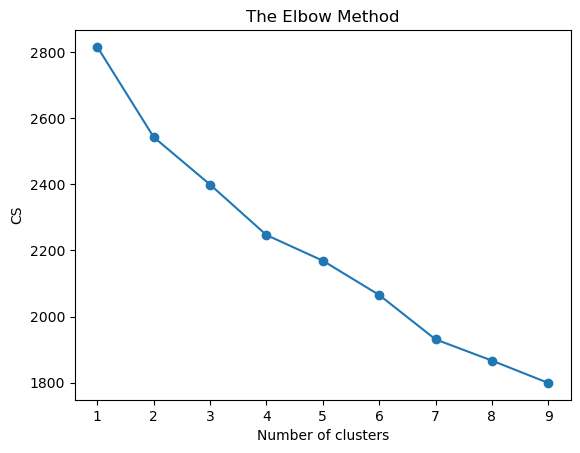

In [60]:
#Doing K-means clustering on the above data of price and age
from sklearn.cluster import KMeans

#Choosing number of clusters for k-means
k_values = list(range(1,10))


inertia = []

#We need to find the optimal value of k
for k in k_values:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(k_values, inertia, marker = 'o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

**Inference:** We can see that 7 is the optimal number of clusters 

In [ ]:
#Creating cluster with the optimal value of k which is 7
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 0)
kmeans.fit(df_scaled)

#Adding cluster number or labels to our cluster for better readability
df_scaled['Cluster Number'] = kmeans.labels_
df_scaled.head()

price  neighbourhood_cleansed_Adams  neighbourhood_cleansed_Alki  \
0  0.061602                           0.0                          0.0   
1  0.128337                           0.0                          0.0   
2  0.975359                           0.0                          0.0   
3  0.436345                           0.0                          0.0   
4  0.097536                           0.0                          0.0   

   neighbourhood_cleansed_Arbor Heights  neighbourhood_cleansed_Atlantic  \
0                                   0.0                              0.0   
1                                   0.0                              0.0   
2                                   0.0                              0.0   
3                                   0.0                              0.0   
4                                   0.0                              0.0   

   neighbourhood_cleansed_Belltown  neighbourhood_cleansed_Bitter Lake  \
0                              0.0                                 0.0   
1                              0.0                                 0.0   
2                              0.0                                 0.0   
3                              0.0                                 0.0   
4                              0.0                                 0.0   

   neighbourhood_cleansed_Briarcliff  neighbourhood_cleansed_Brighton  \
0                                0.0                              0.0   
1                                0.0                              0.0   
2                                0.0                              0.0   
3                                0.0                              0.0   
4                                0.0                              0.0   

   neighbourhood_cleansed_Broadview  ...  neighbourhood_cleansed_View Ridge  \
0                               0.0  ...                                0.0   
1                               0.0  ...                                0.0   
2                               0.0  ...                                0.0   
3                               0.0  ...                                0.0   
4                               0.0  ...                                0.0   

   neighbourhood_cleansed_Wallingford  neighbourhood_cleansed_Wedgwood  \
0                                 0.0                              0.0   
1                                 0.0                              0.0   
2                                 0.0                              0.0   
3                                 0.0                              0.0   
4                                 0.0                              0.0   

   neighbourhood_cleansed_West Queen Anne  \
0                                     1.0   
1                                     1.0   
2                                     1.0   
3                                     1.0   
4                                     1.0   

   neighbourhood_cleansed_West Woodland  neighbourhood_cleansed_Westlake  \
0                                   0.0                              0.0   
1                                   0.0                              0.0   
2                                   0.0                              0.0   
3                                   0.0                              0.0   
4                                   0.0                              0.0   

   neighbourhood_cleansed_Whittier Heights  neighbourhood_cleansed_Windermere  \
0                                      0.0                                0.0   
1                                      0.0                                0.0   
2                                      0.0                                0.0   
3                                      0.0                                0.0   
4                                      0.0                                0.0   

   neighbourhood_cleansed_Yesler Terrace  Cluster Number  
0                         

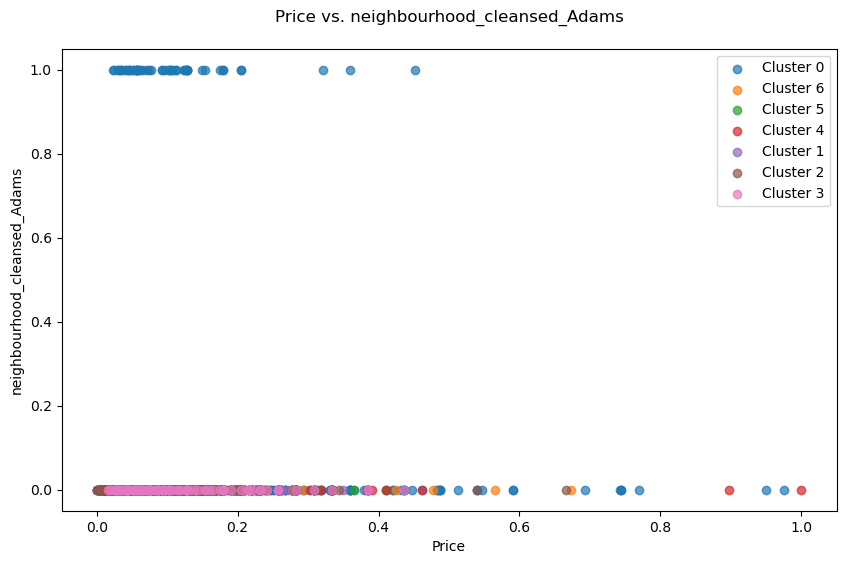

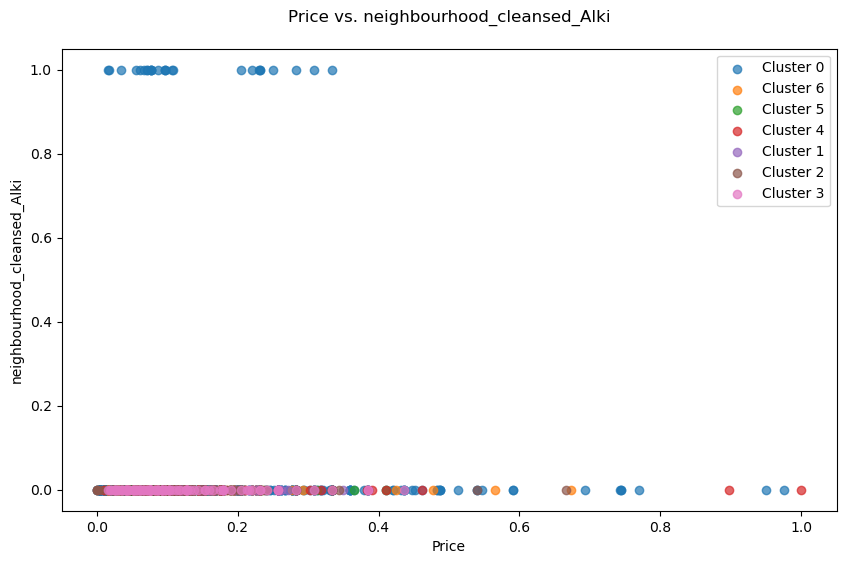

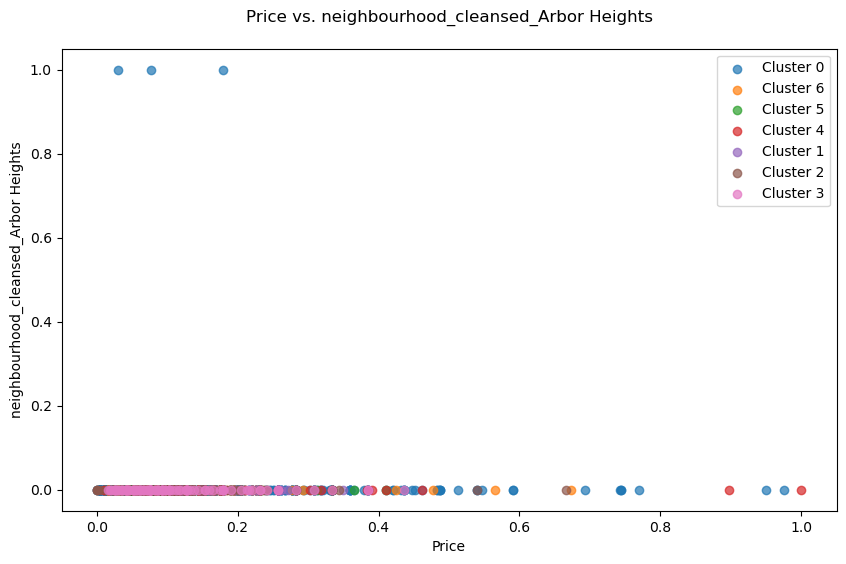

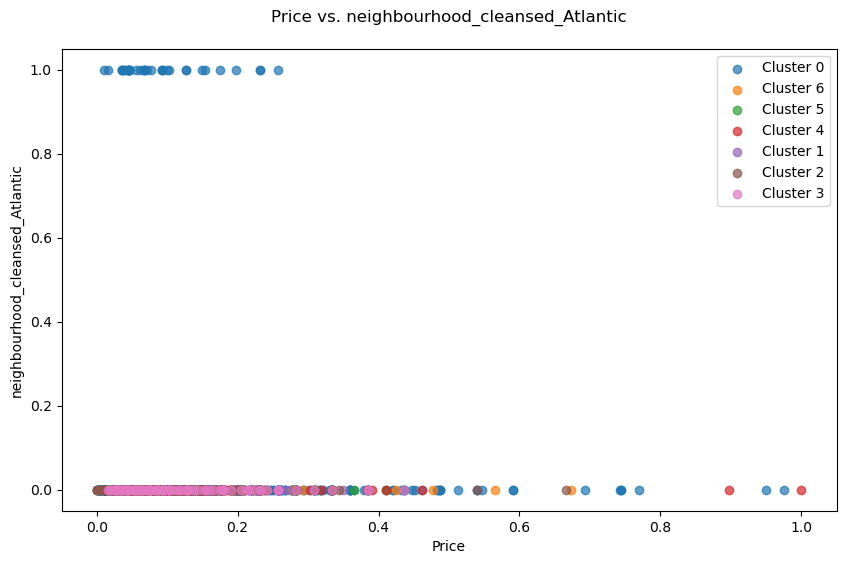

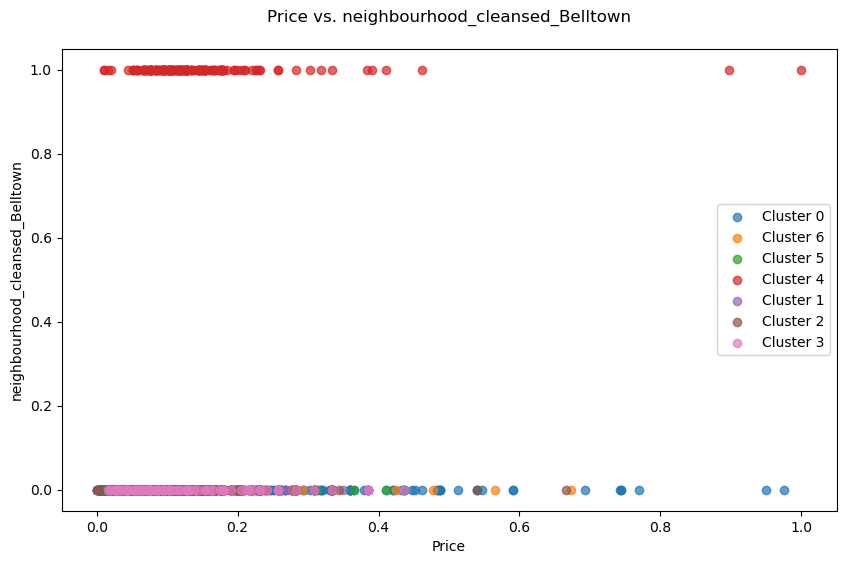

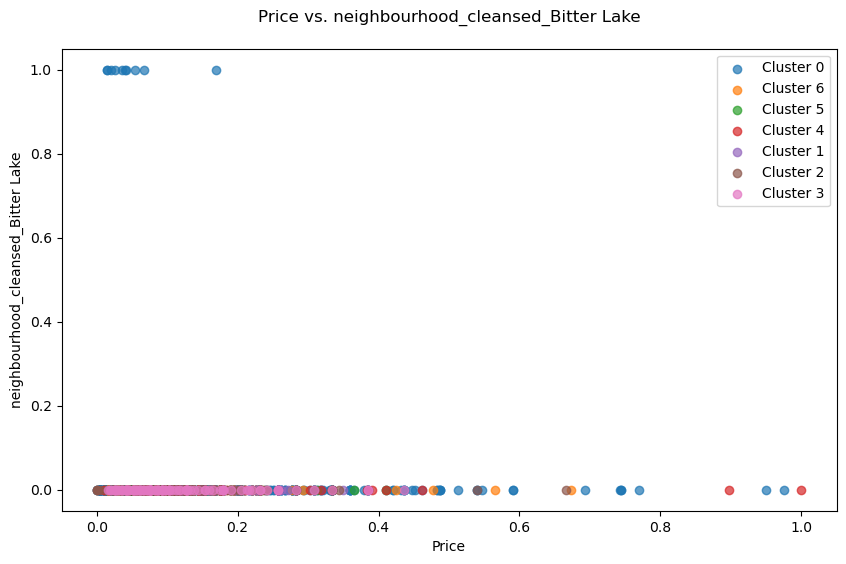

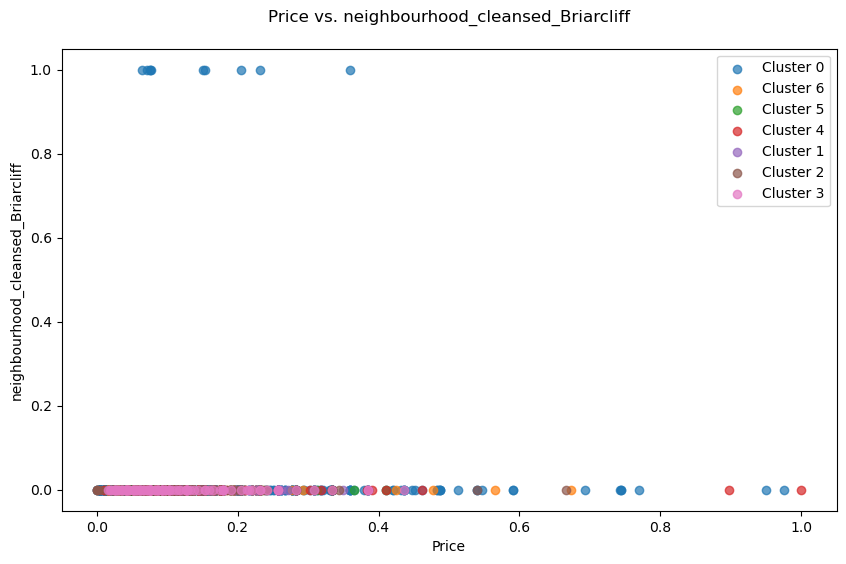

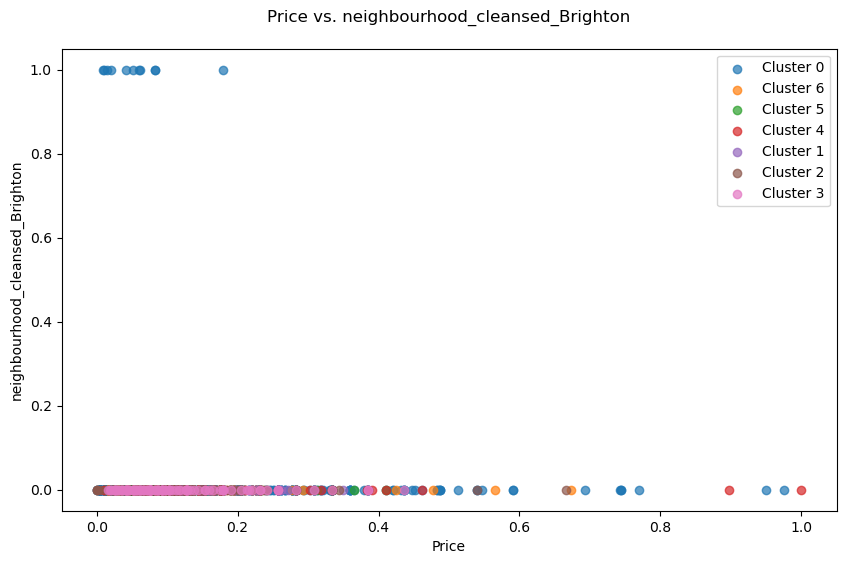

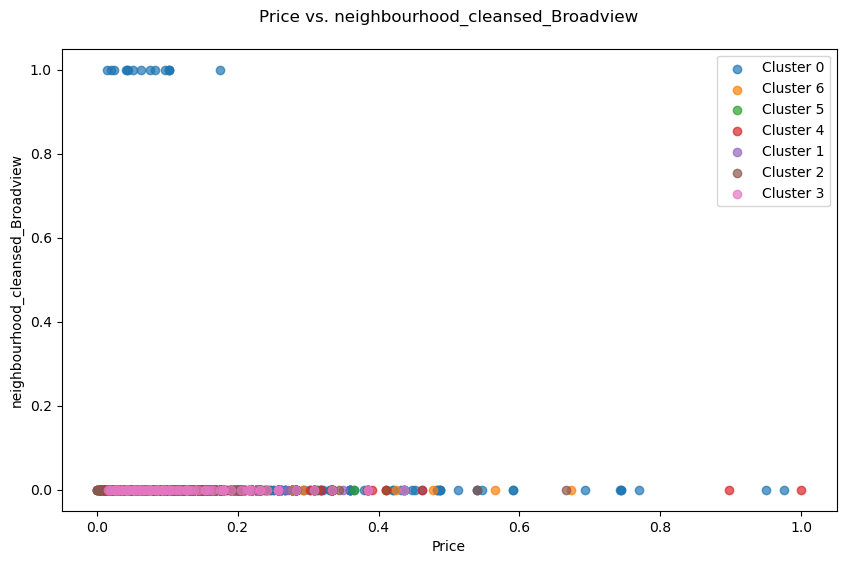

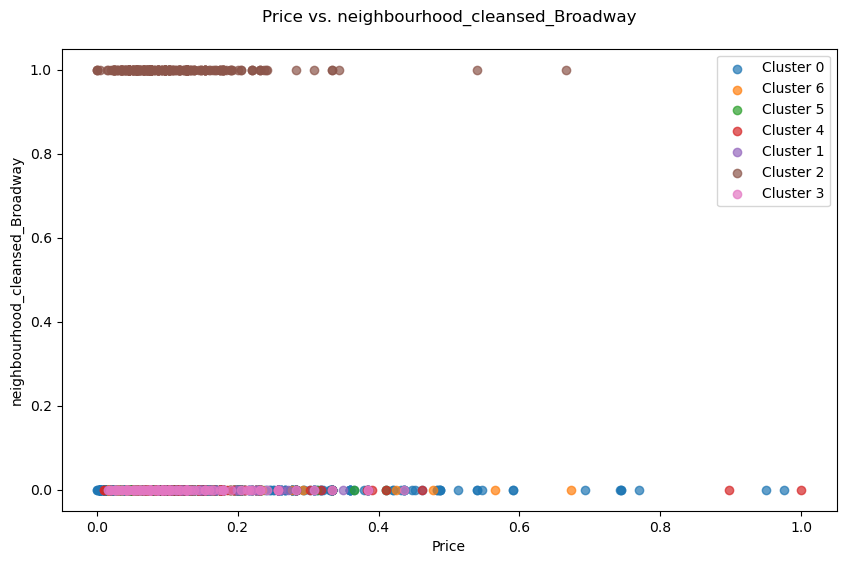

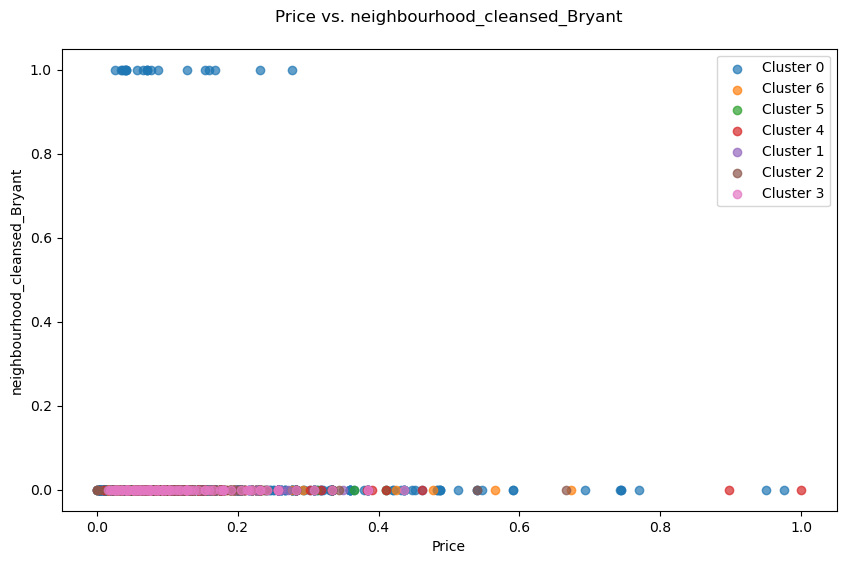

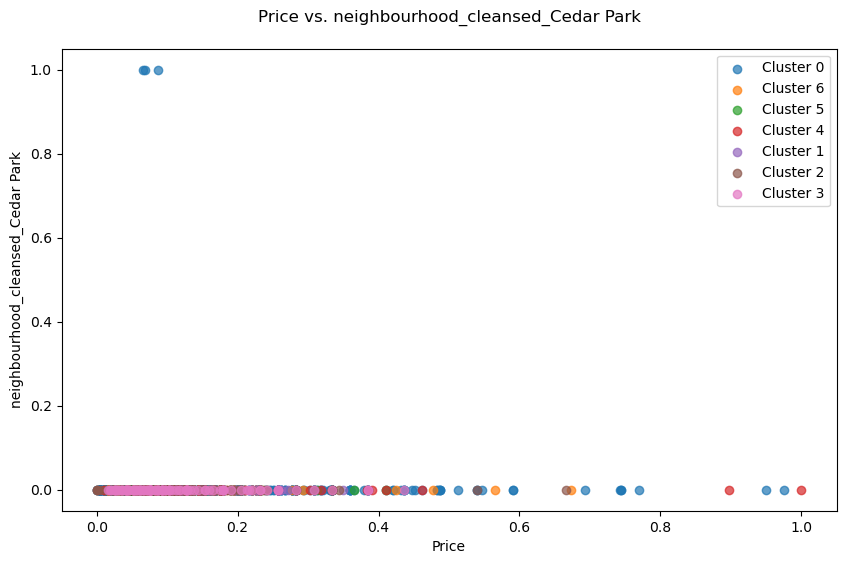

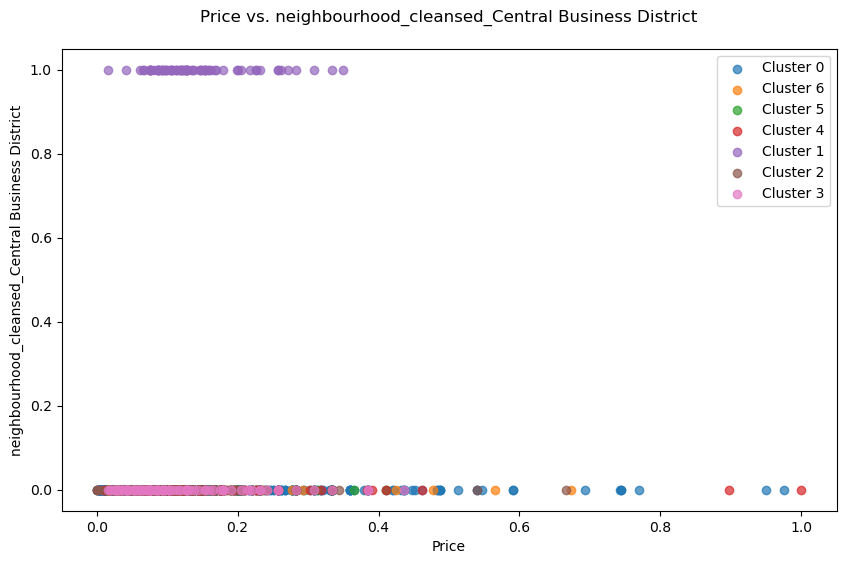

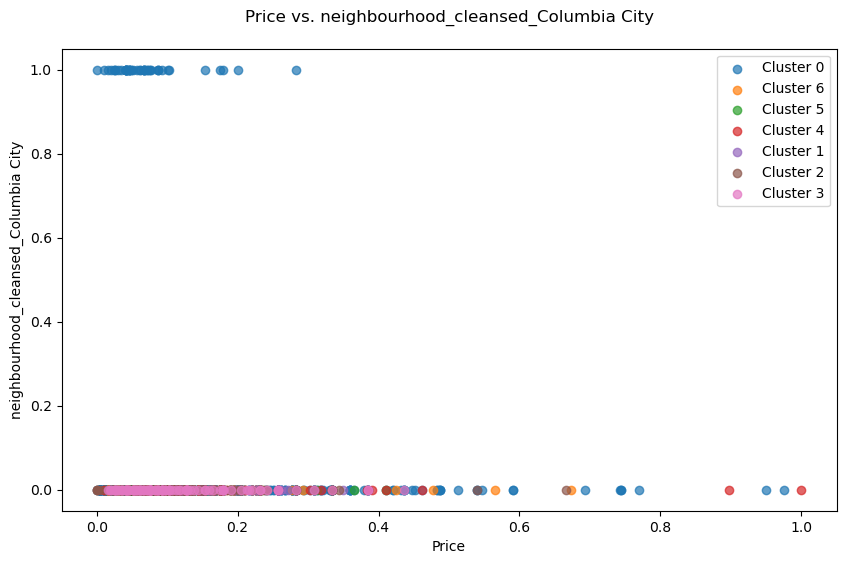

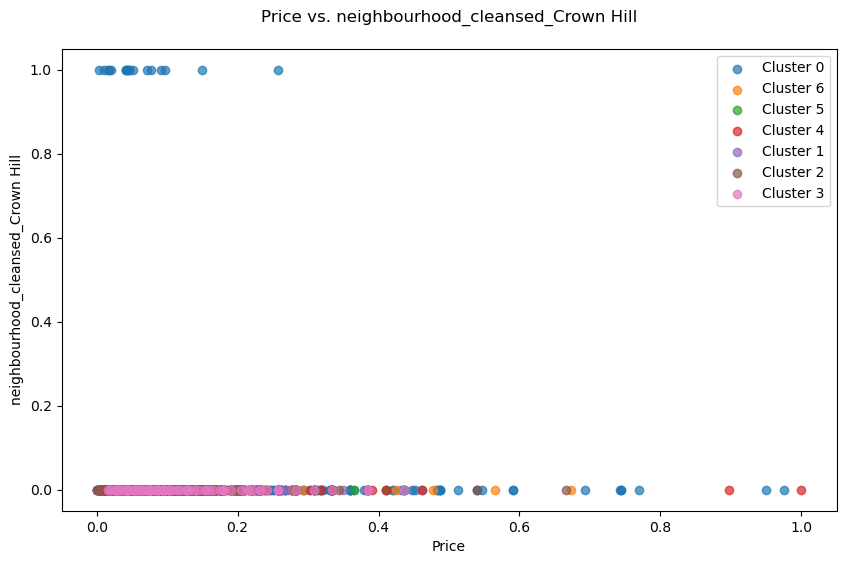

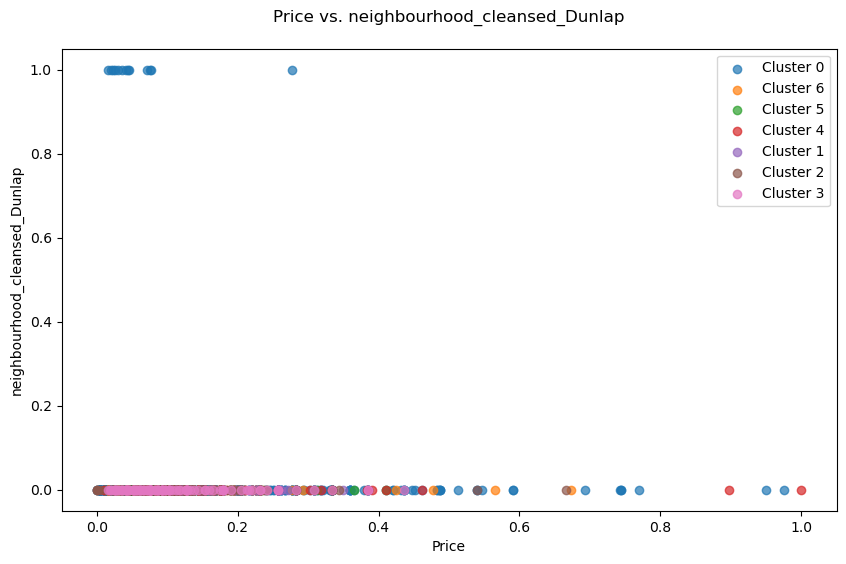

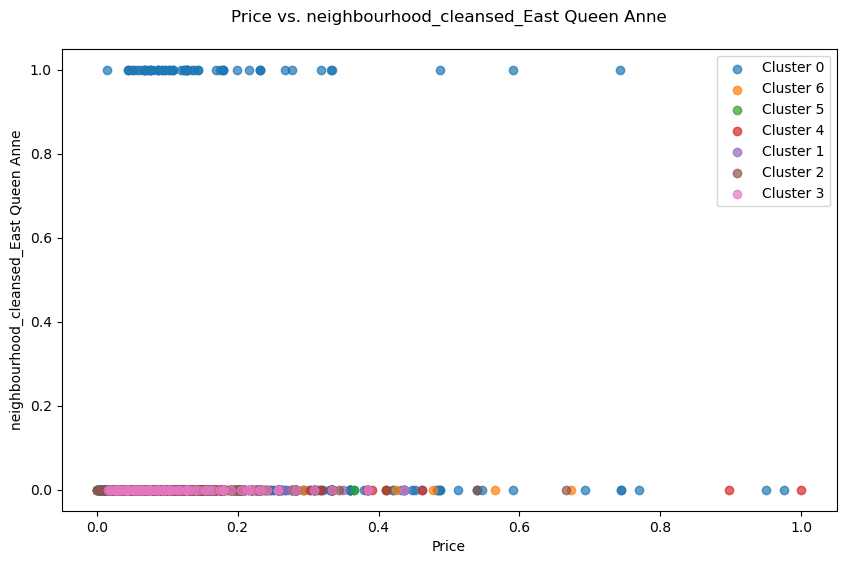

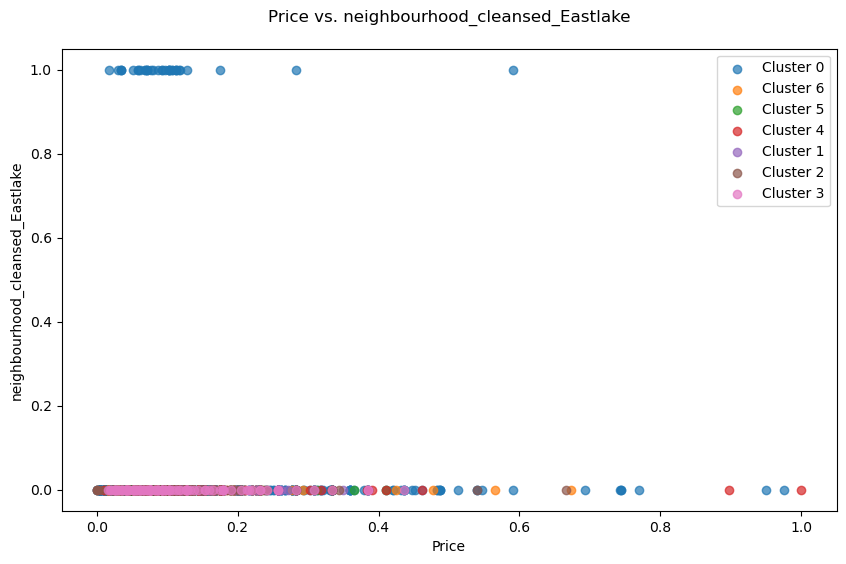

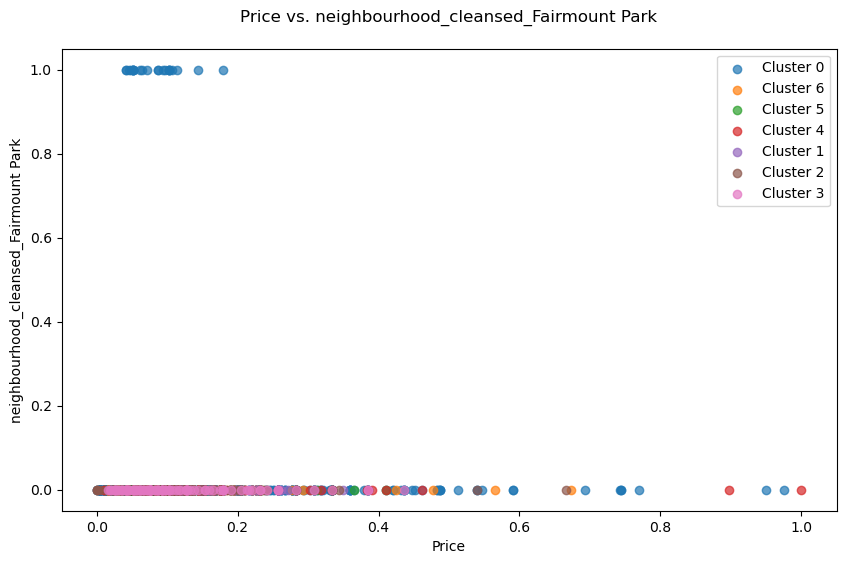

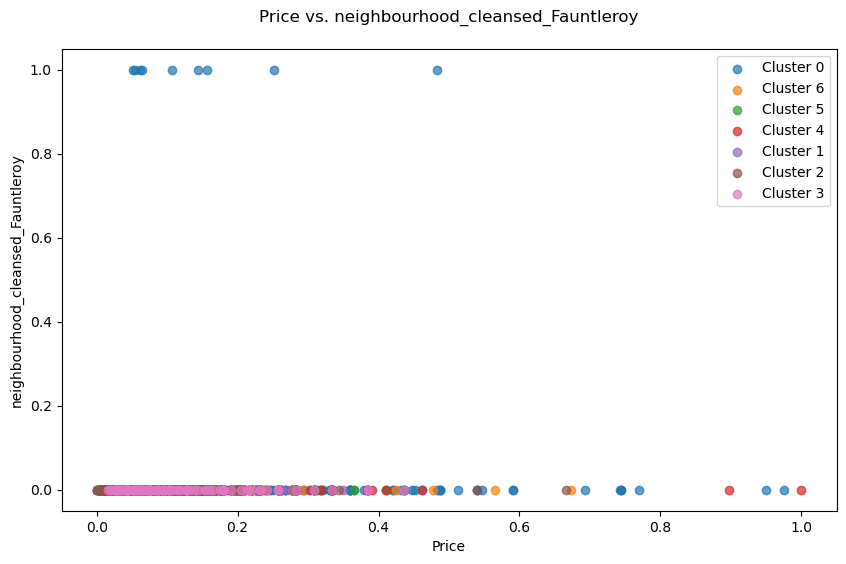

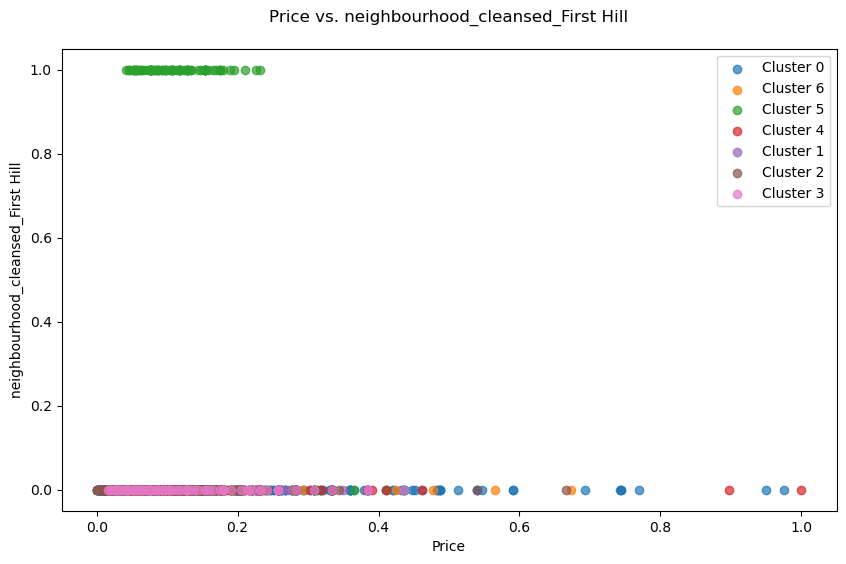

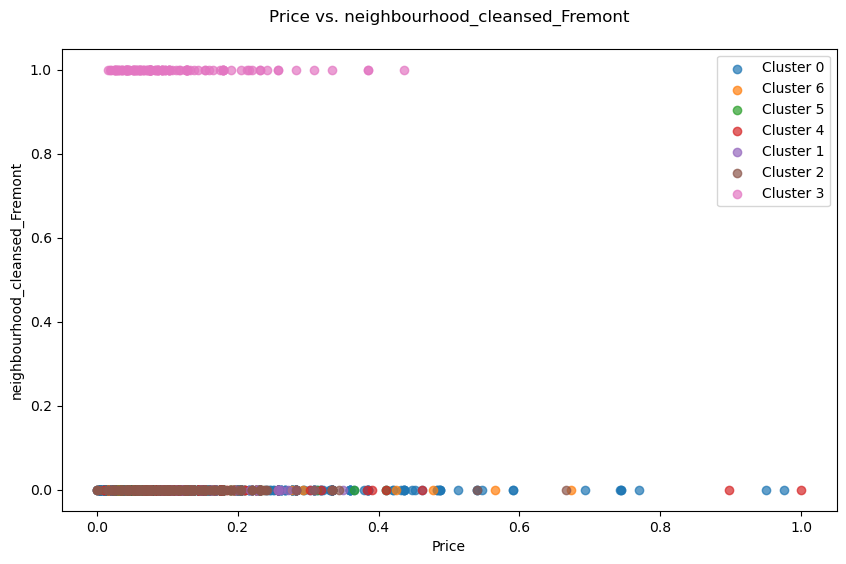

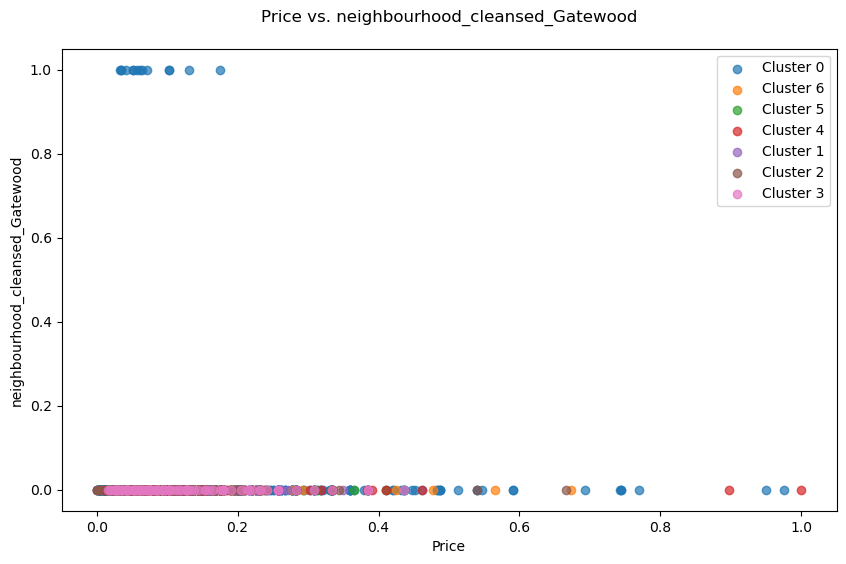

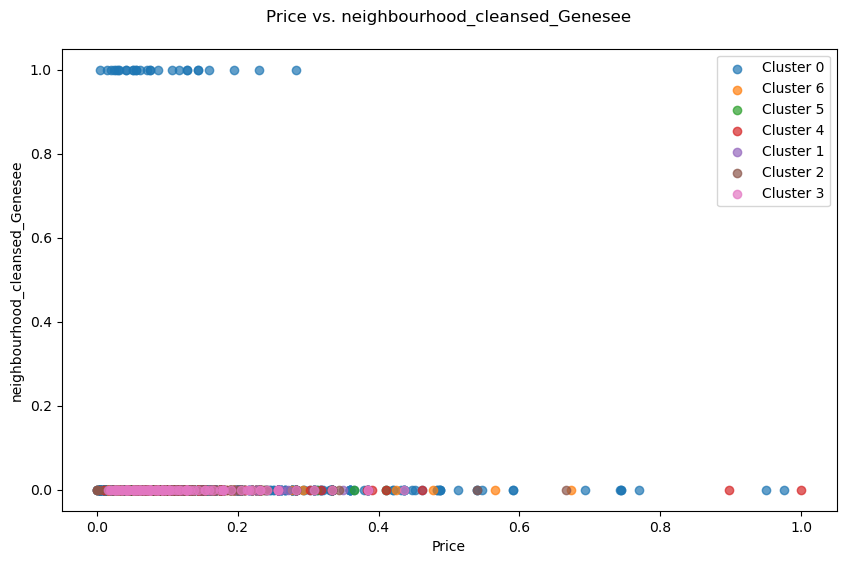

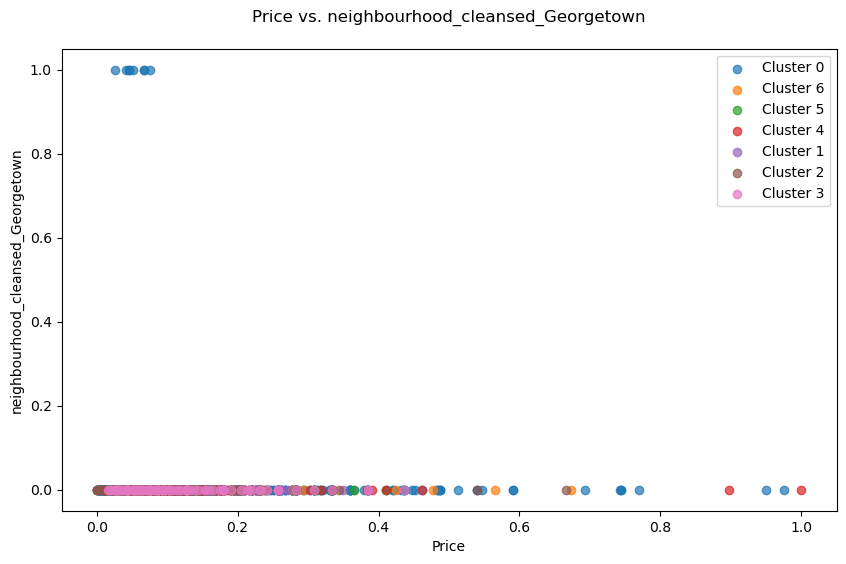

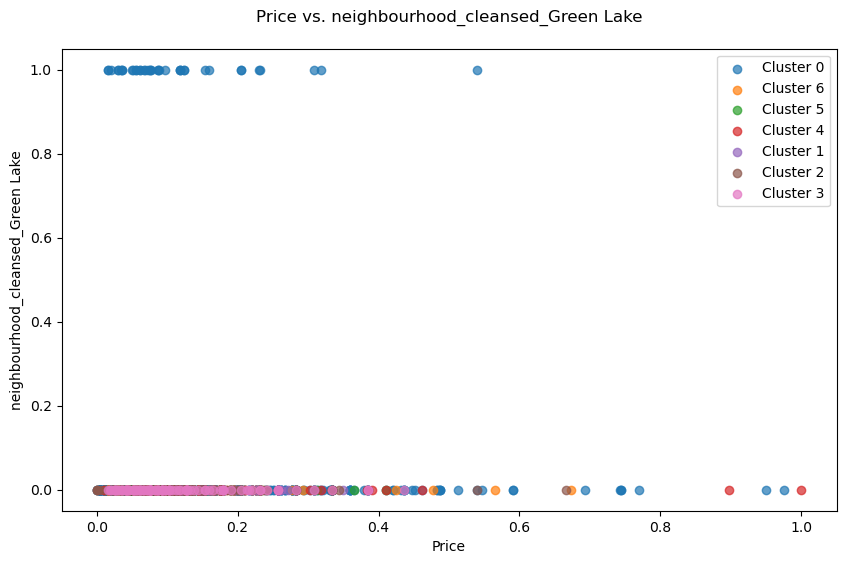

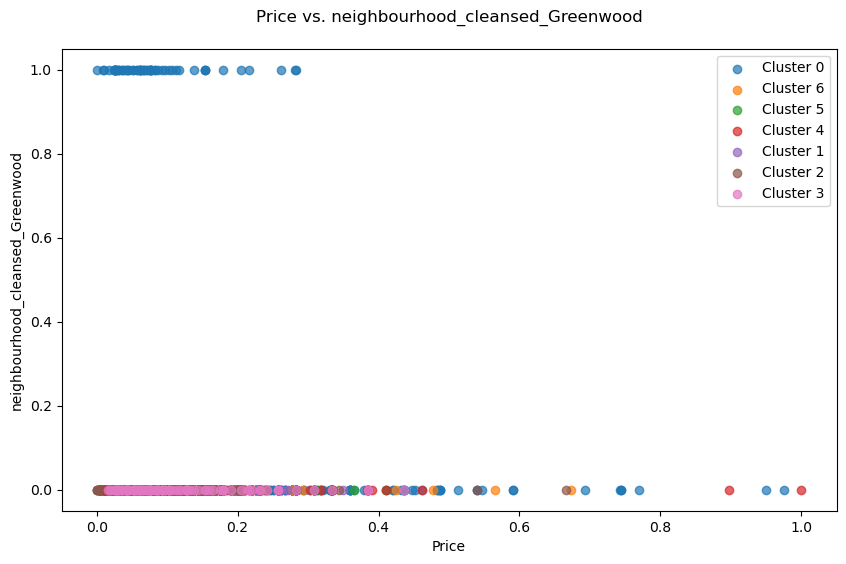

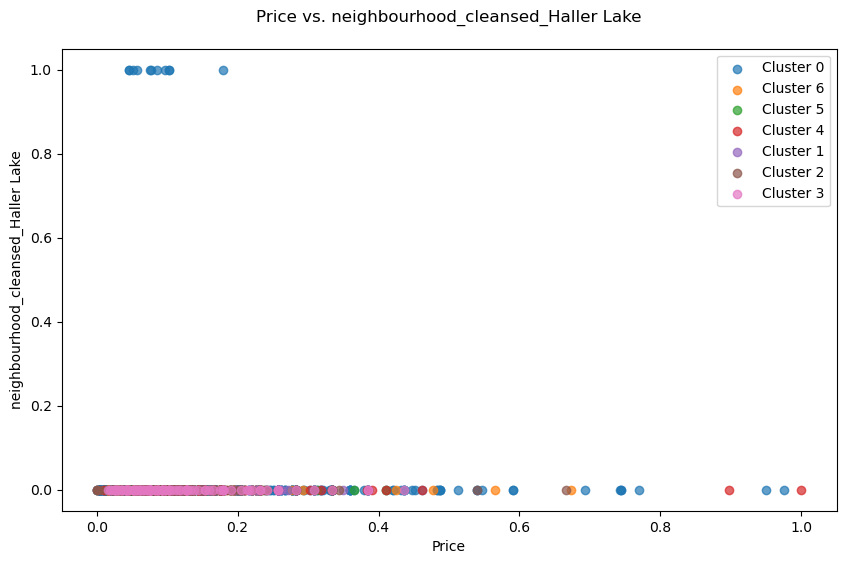

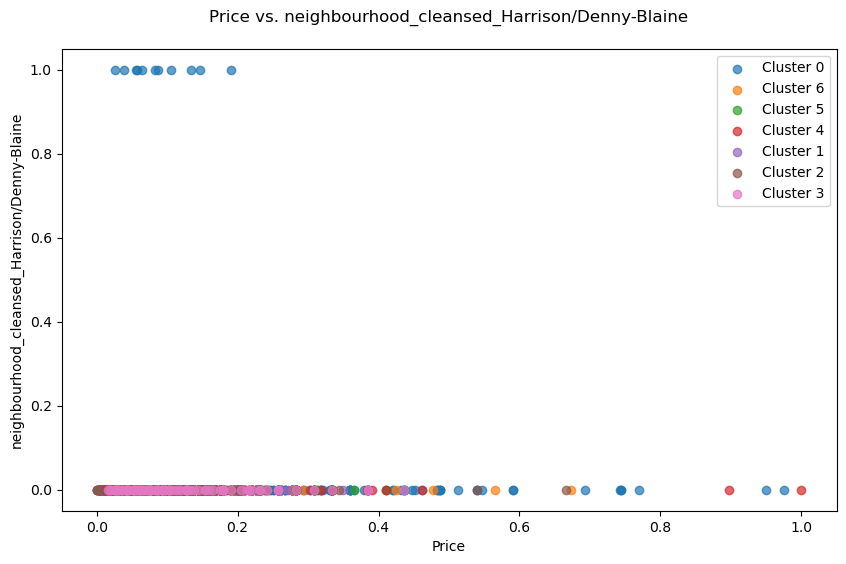

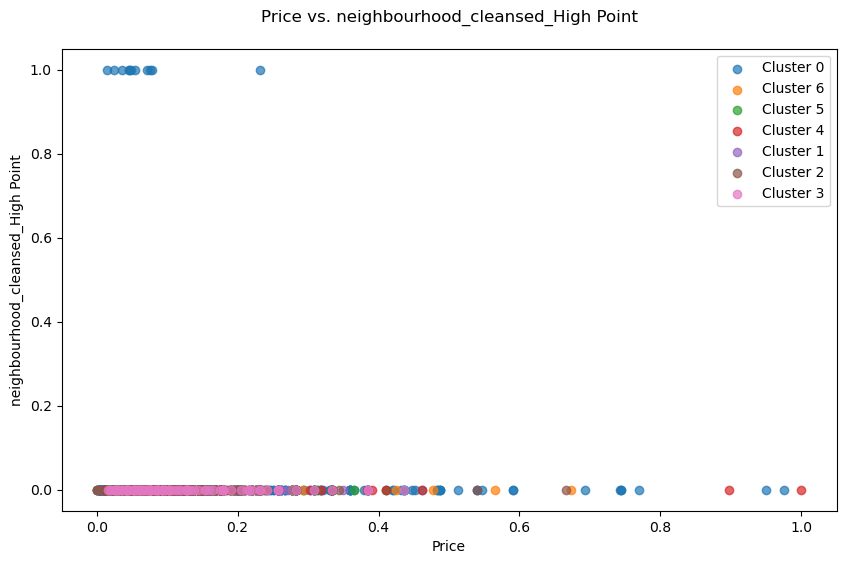

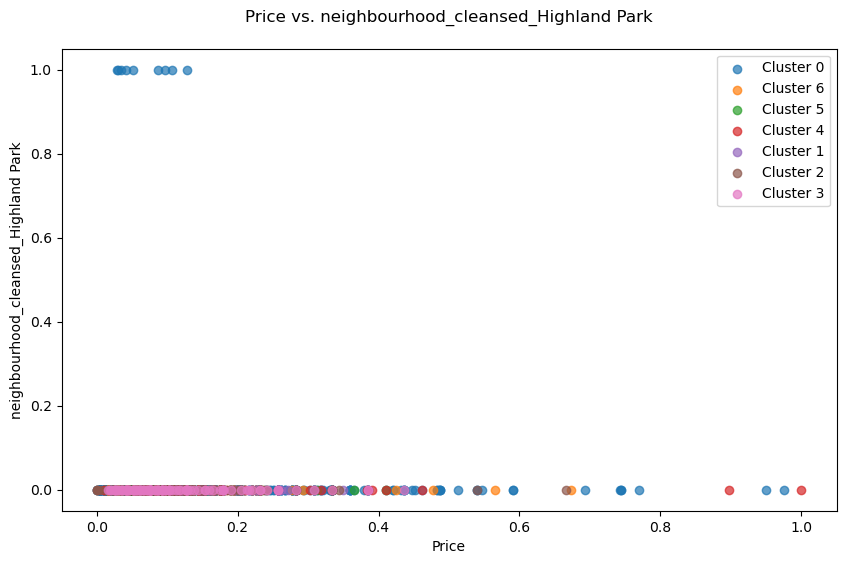

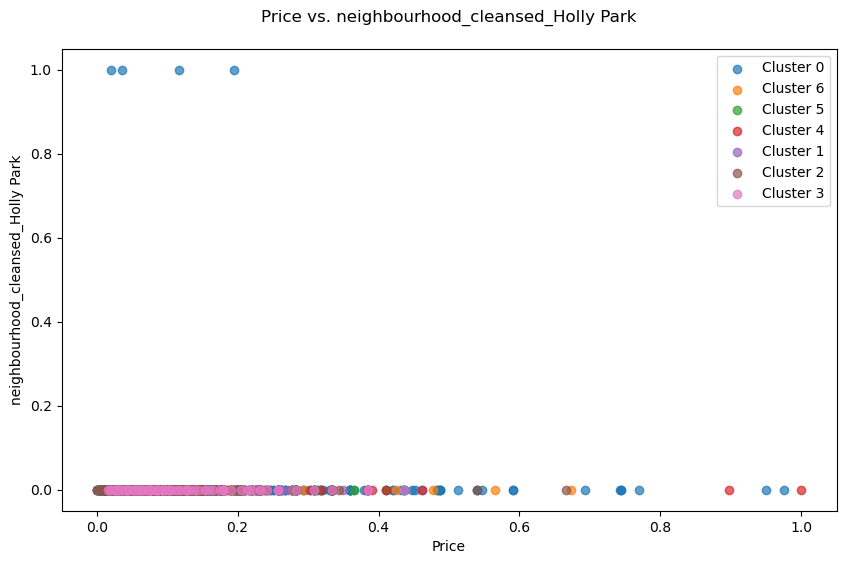

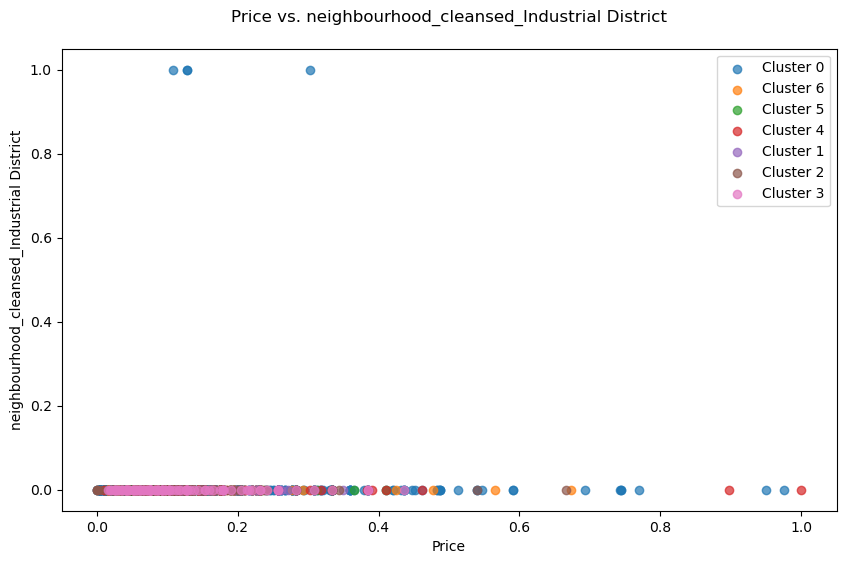

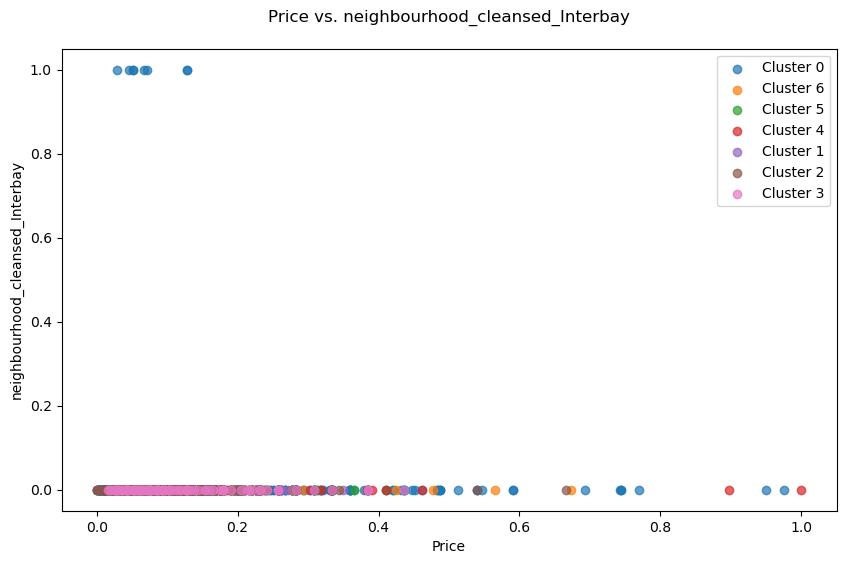

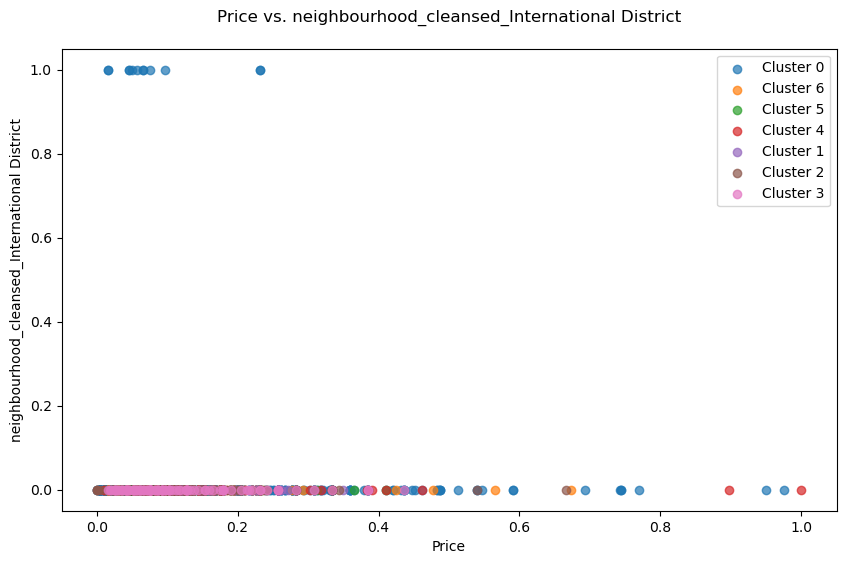

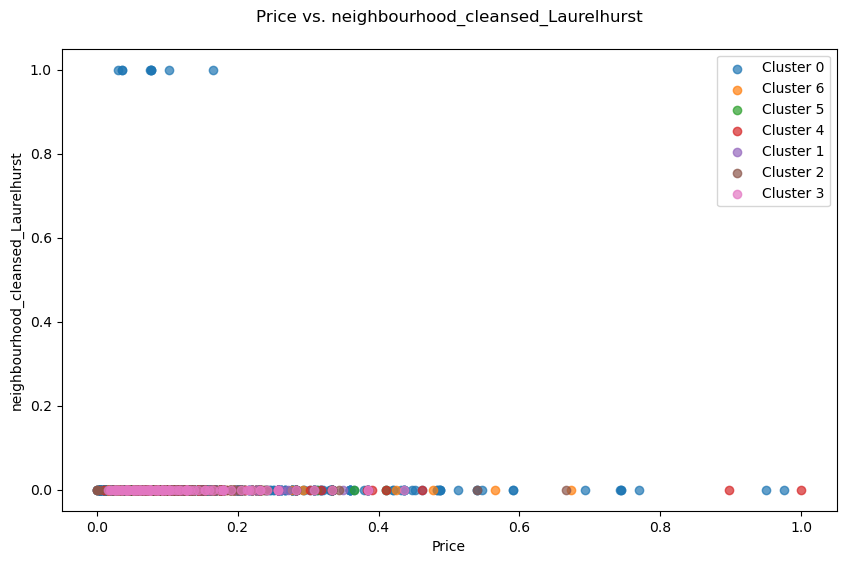

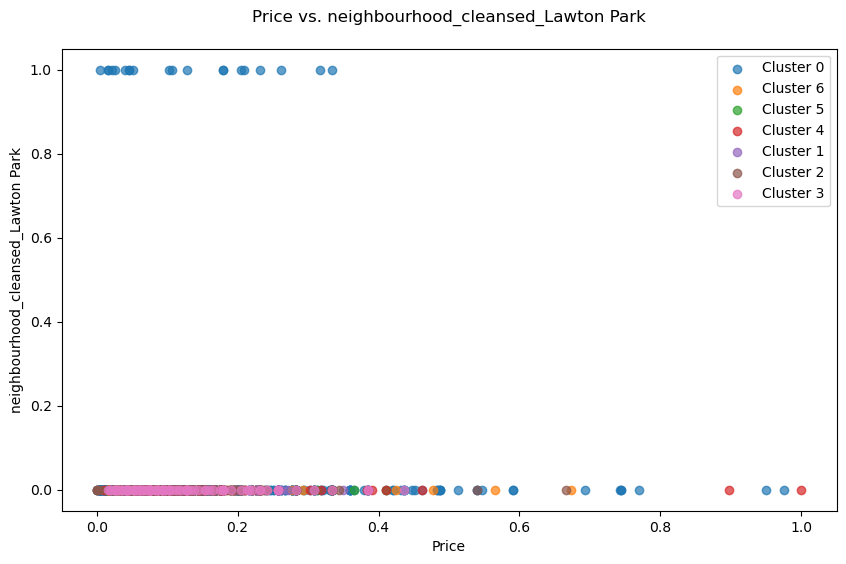

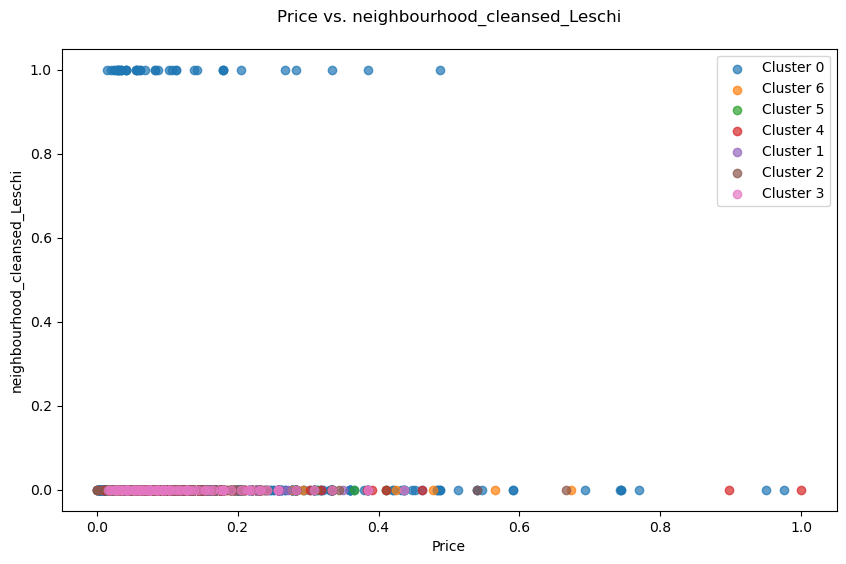

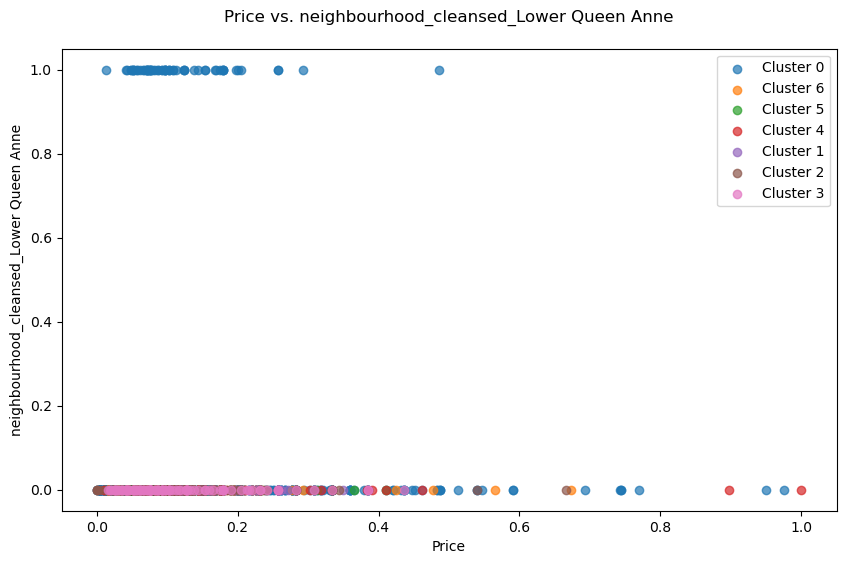

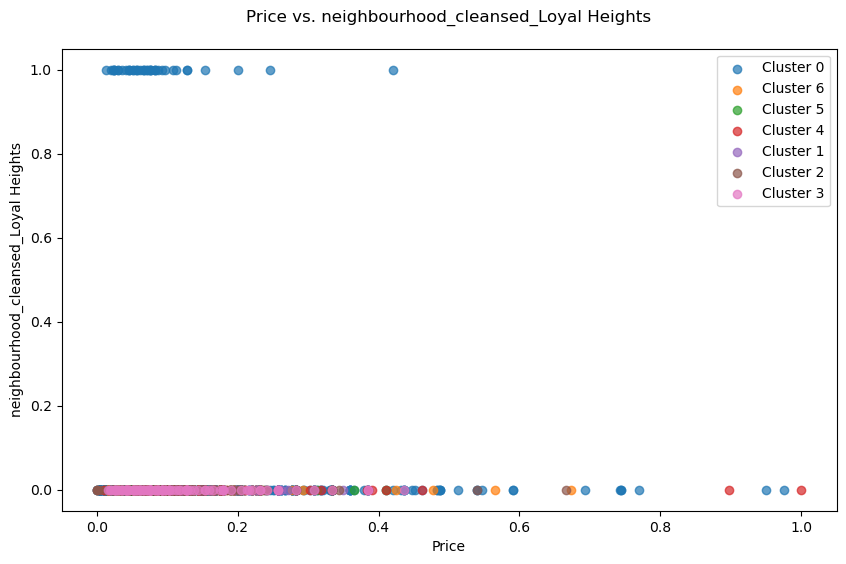

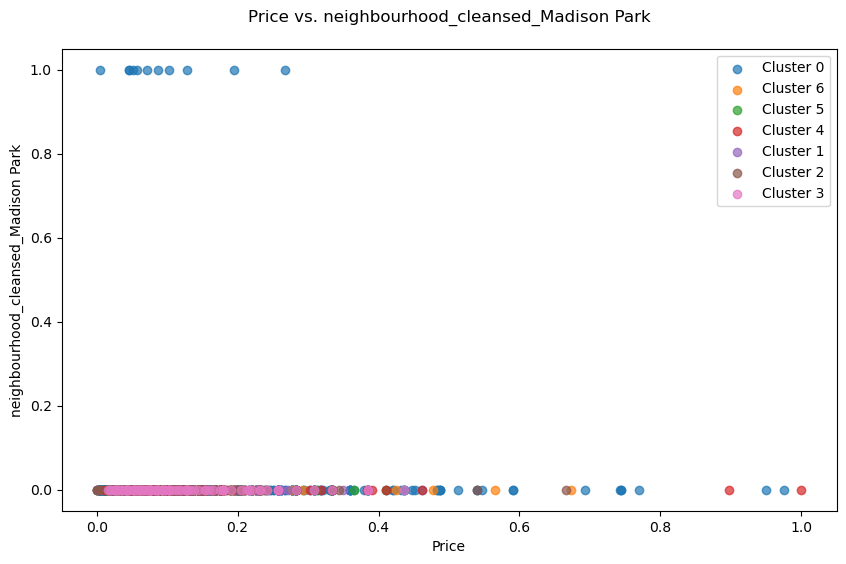

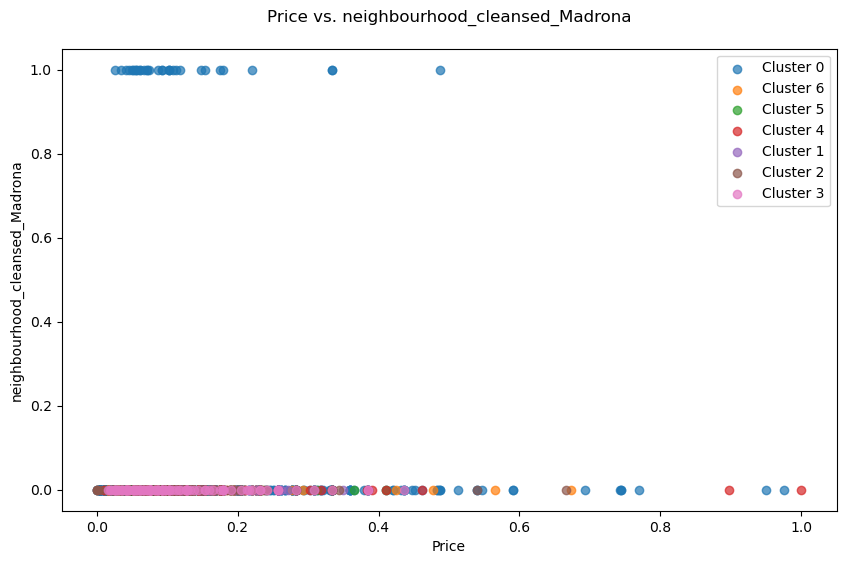

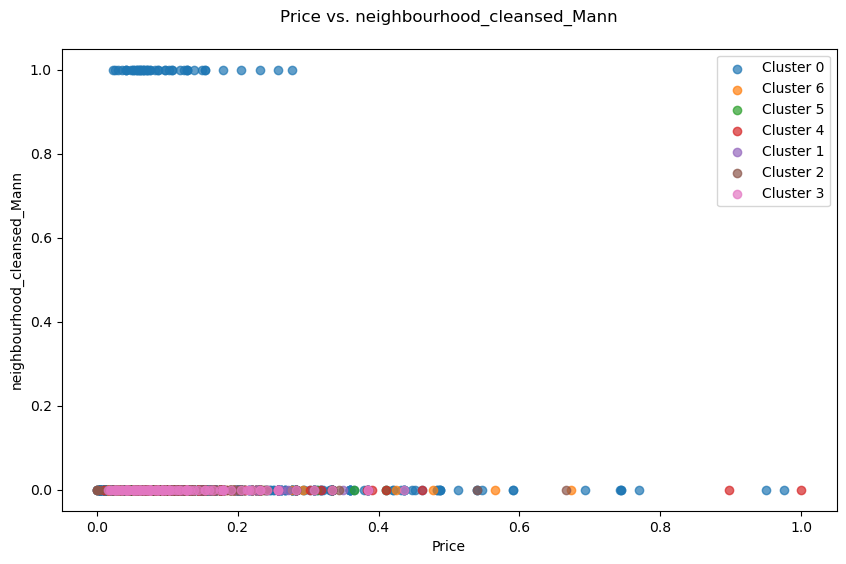

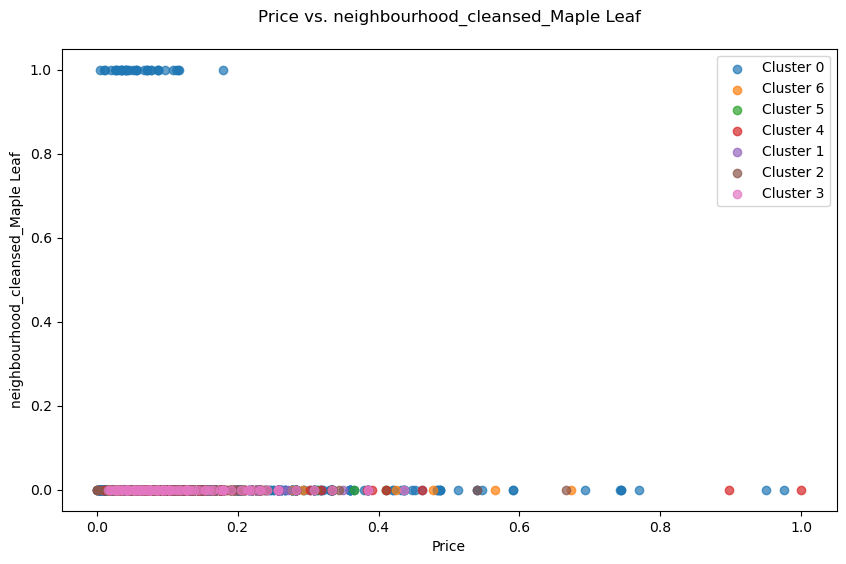

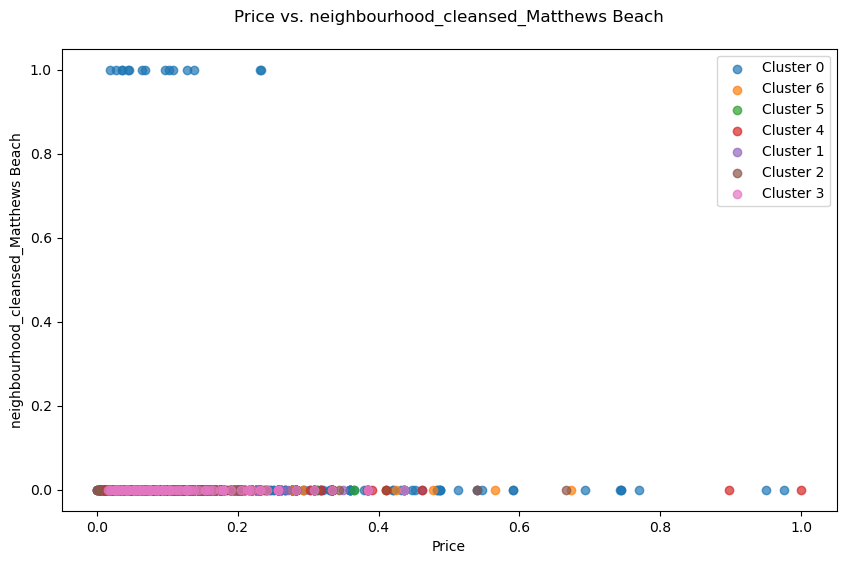

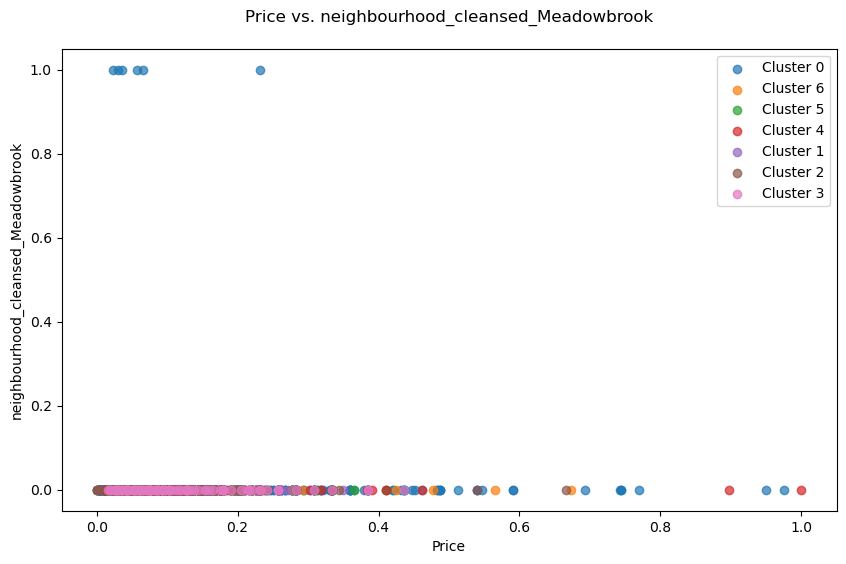

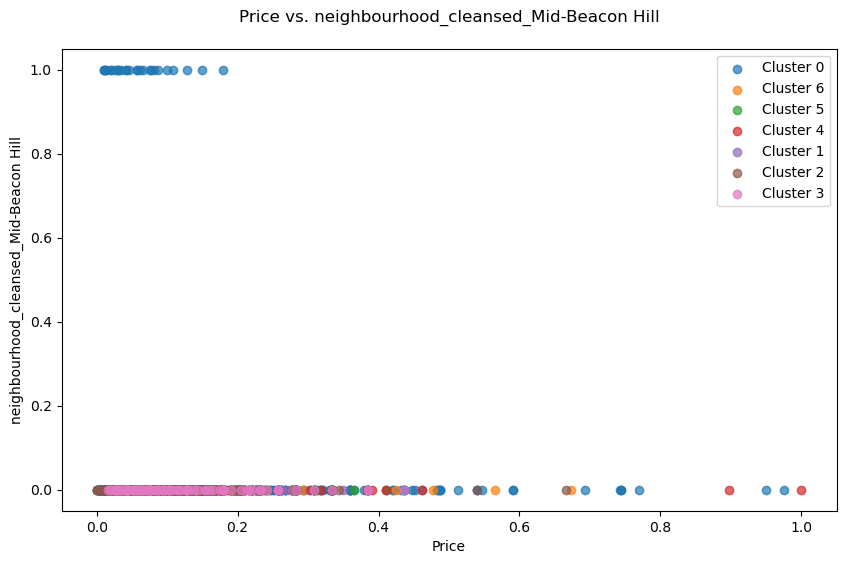

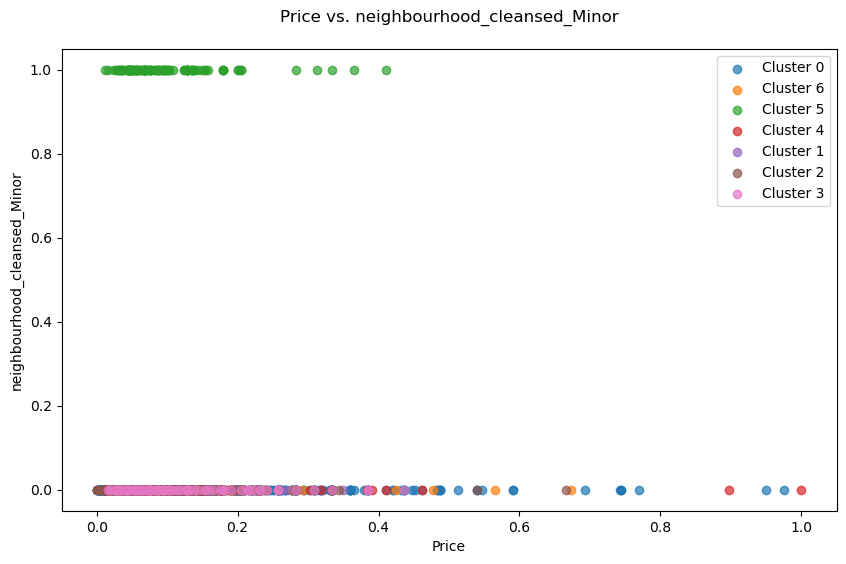

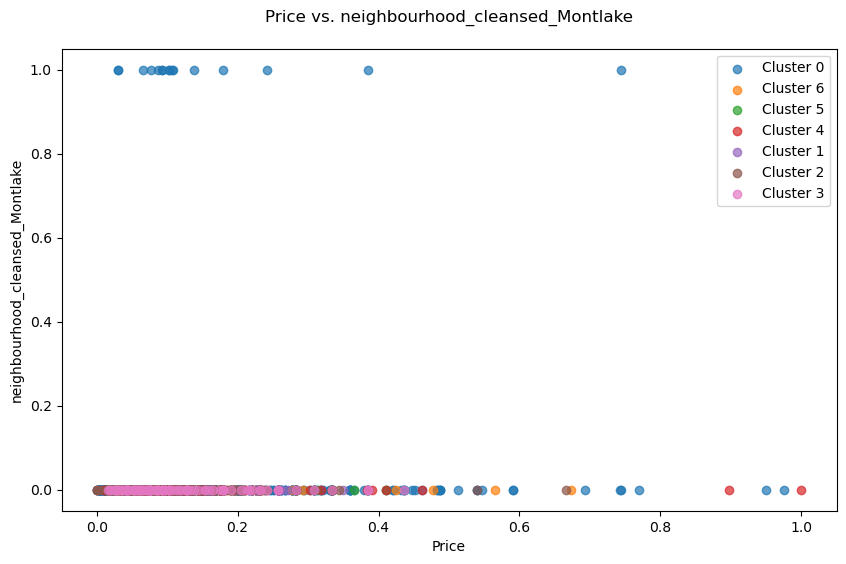

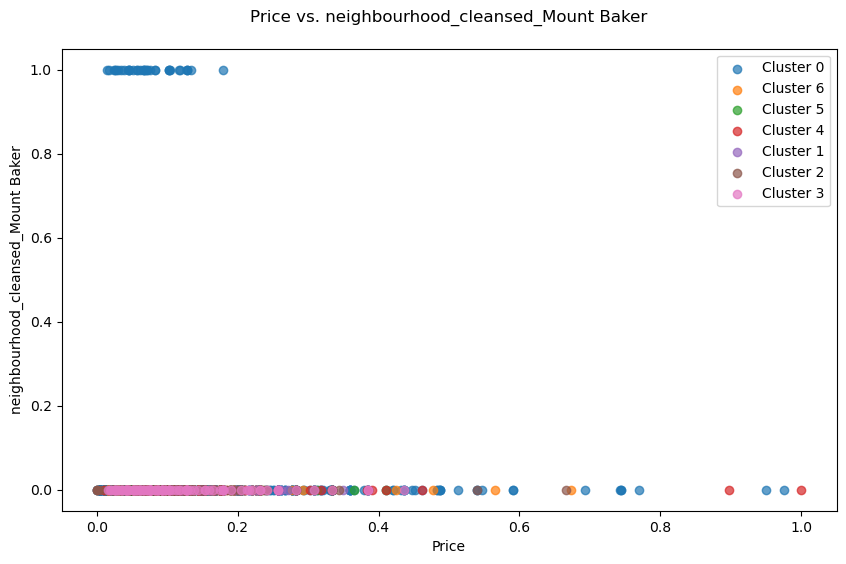

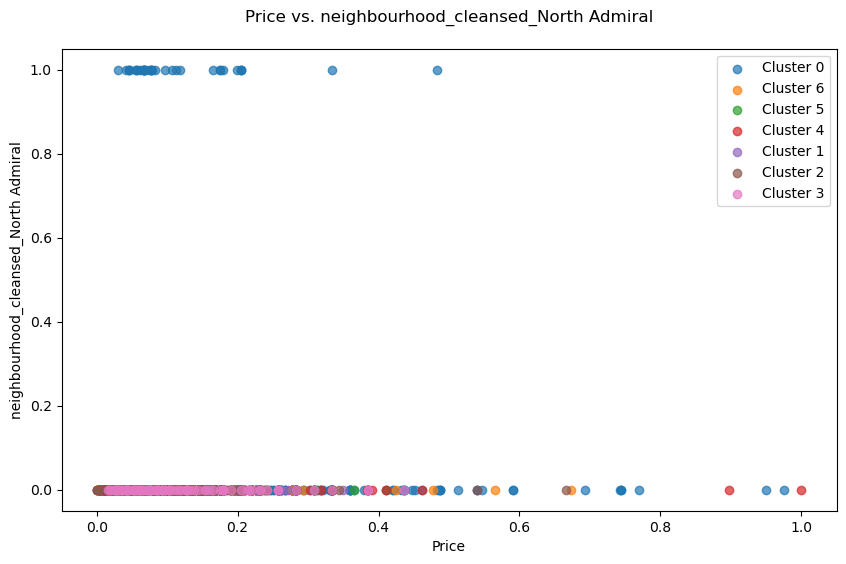

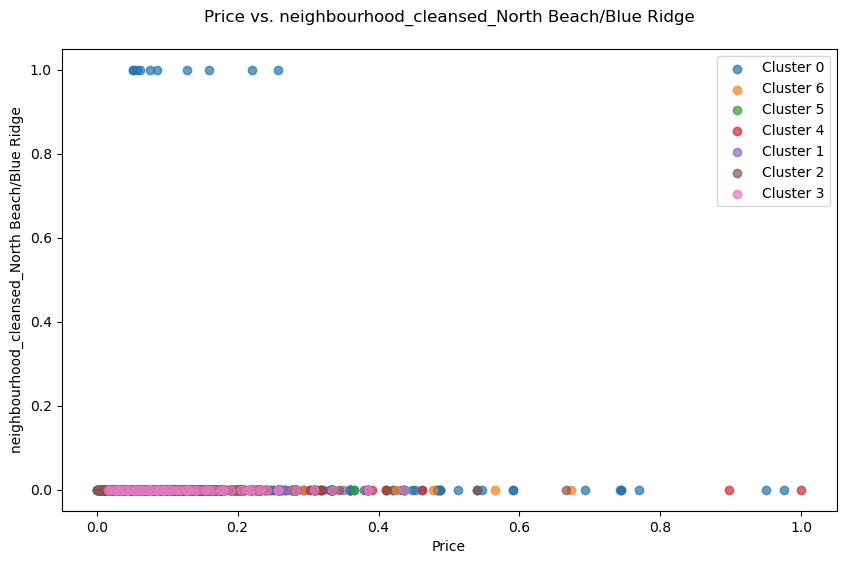

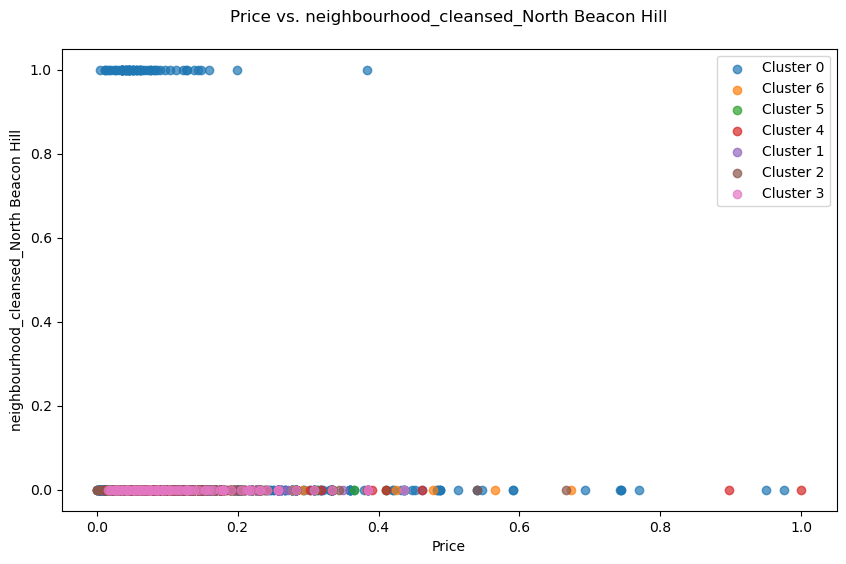

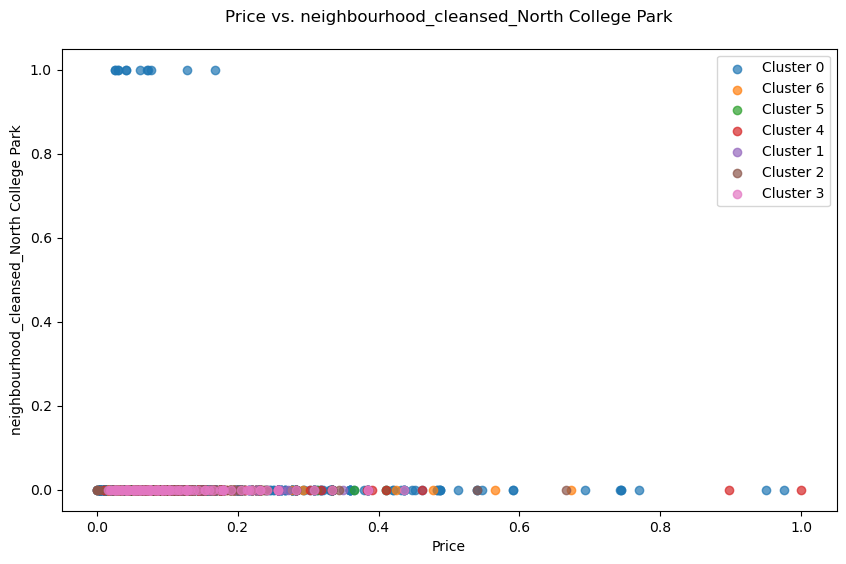

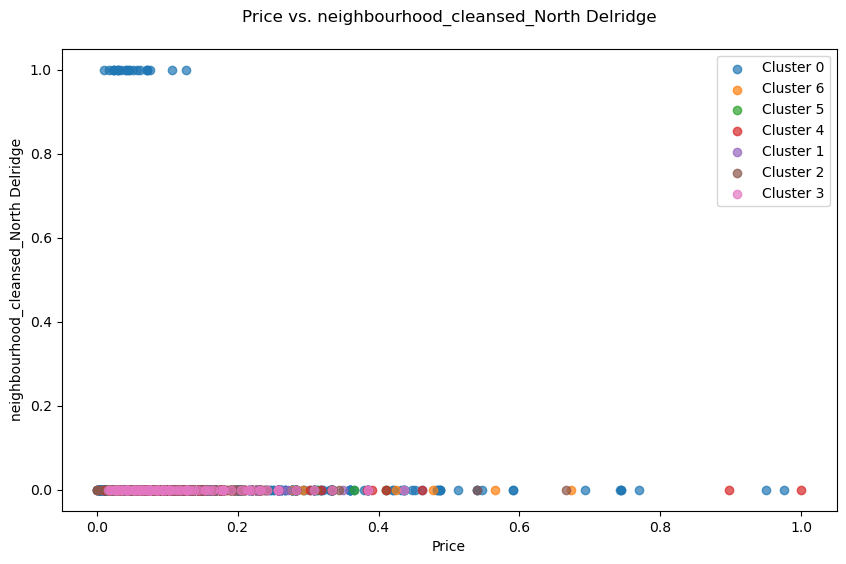

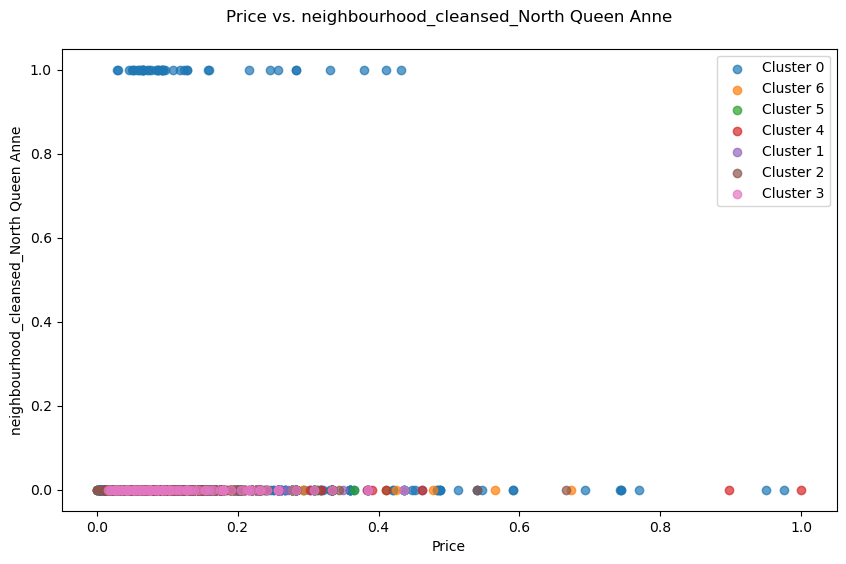

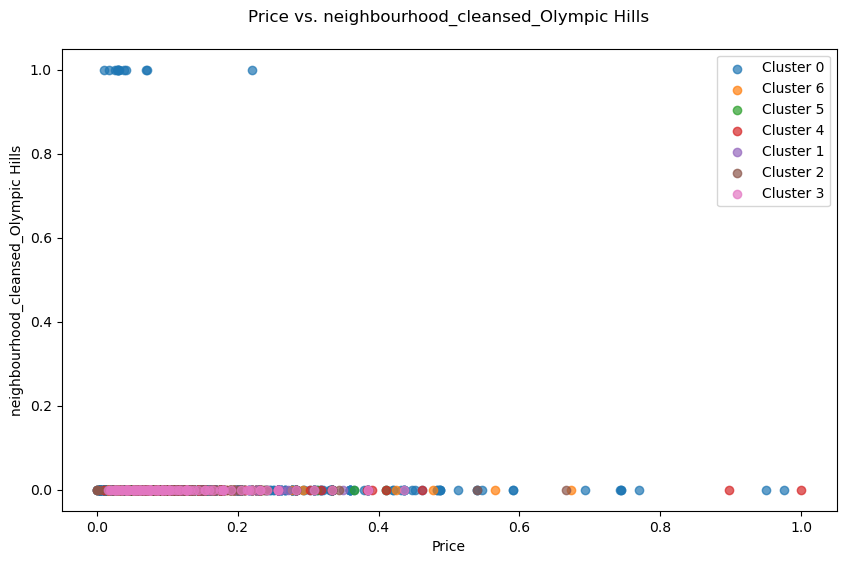

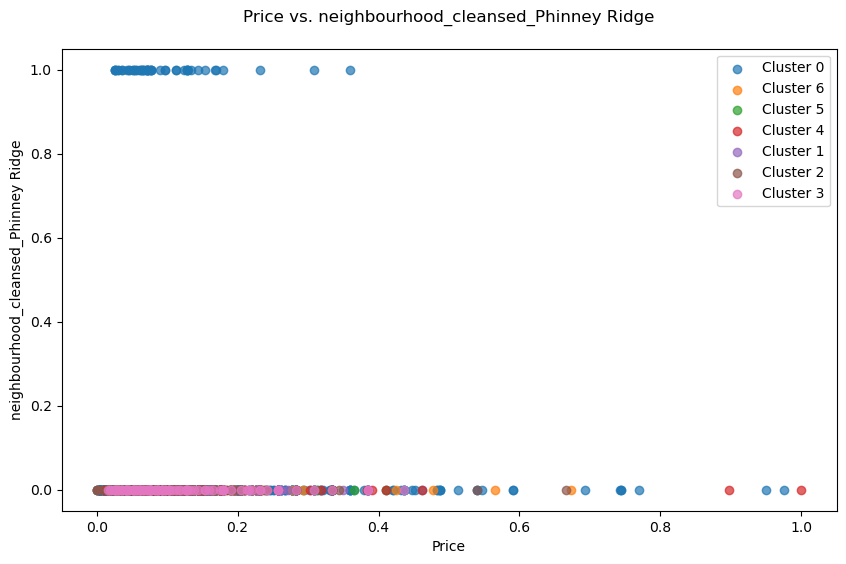

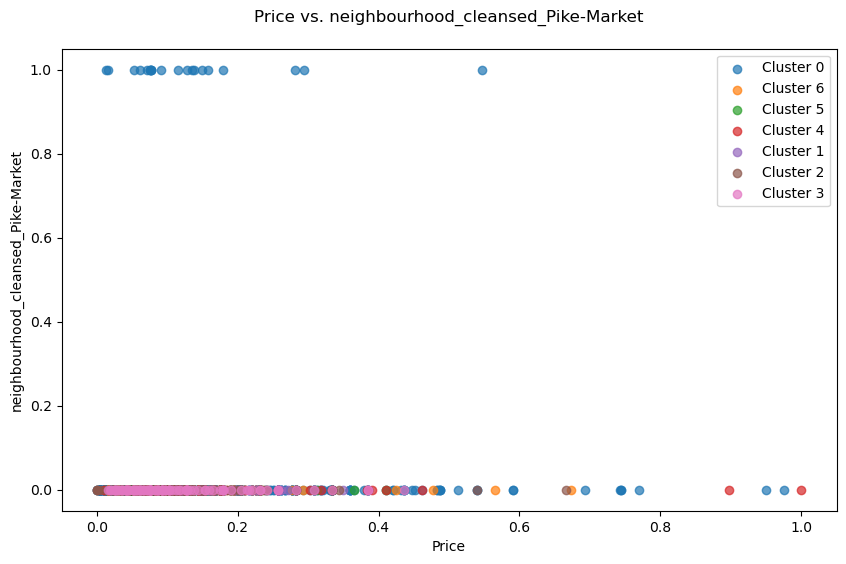

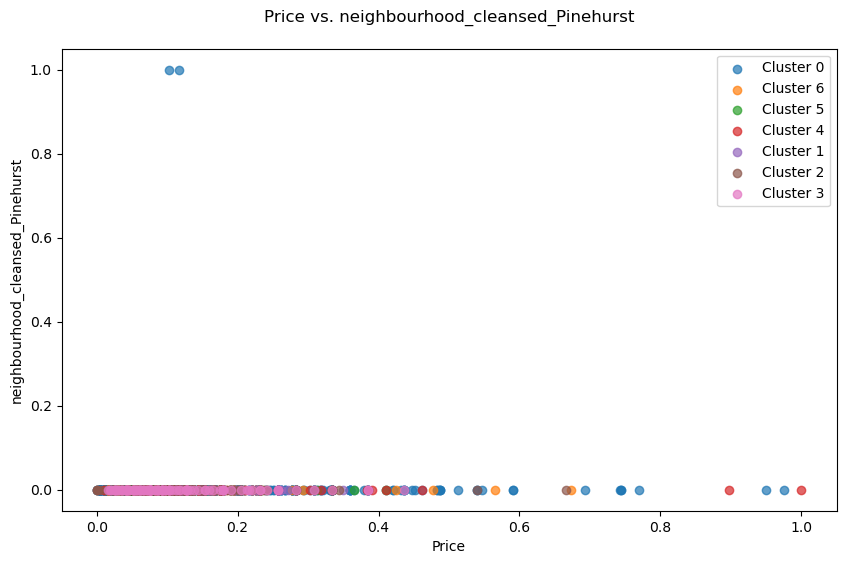

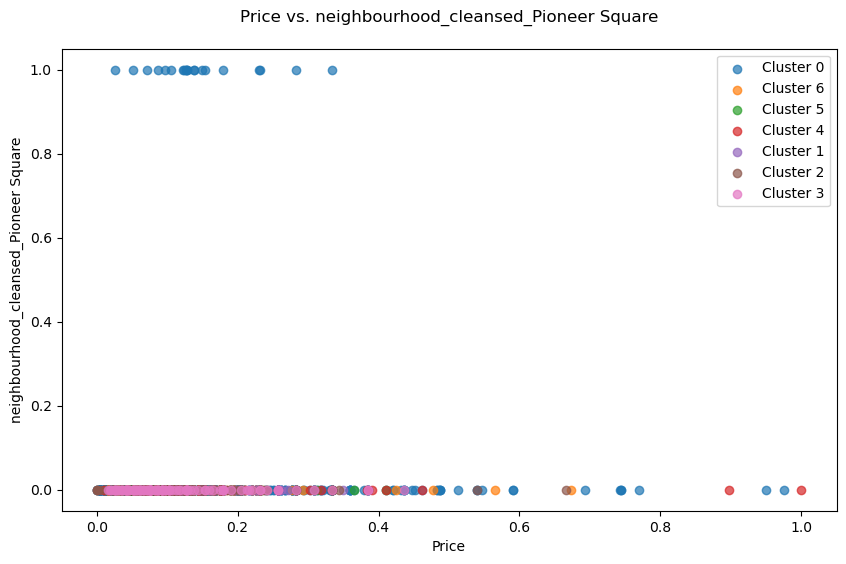

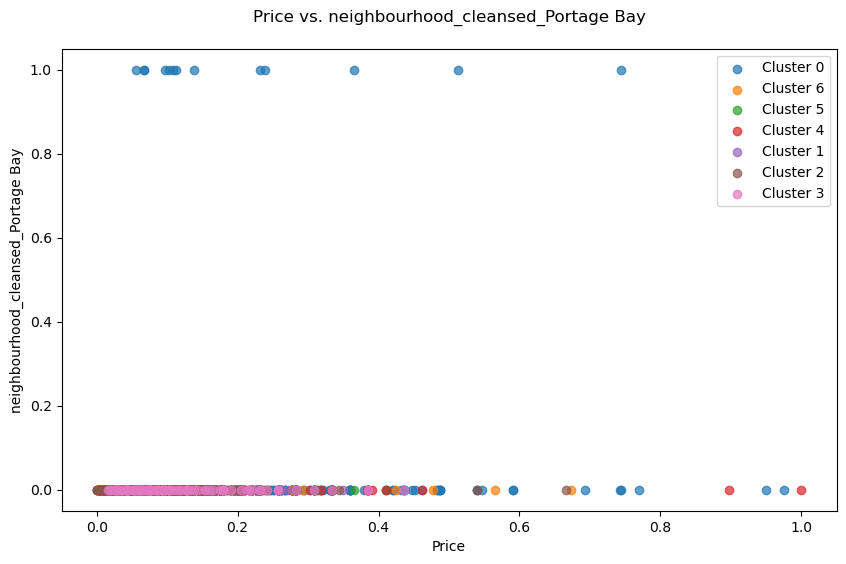

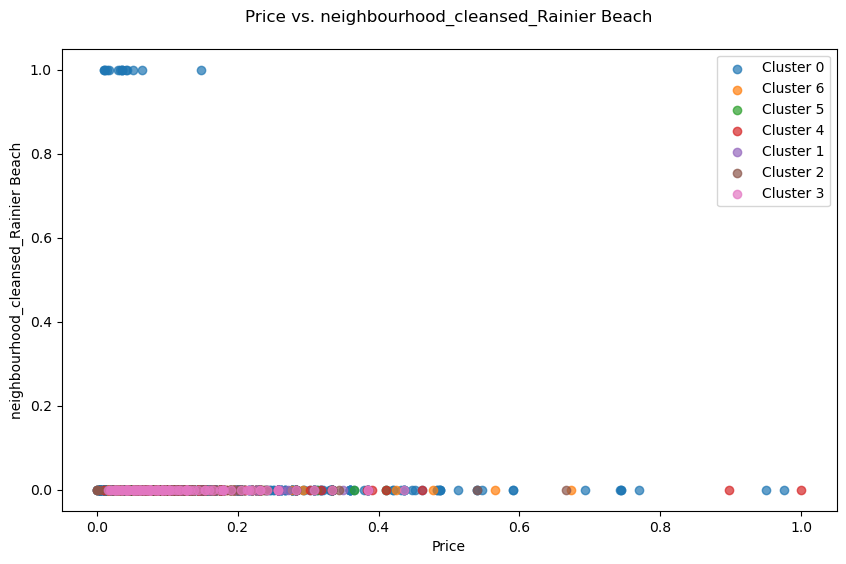

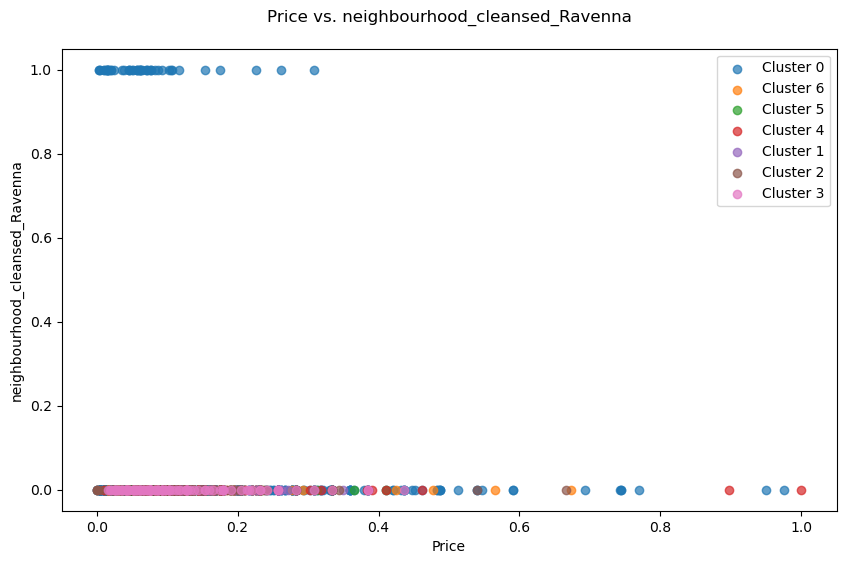

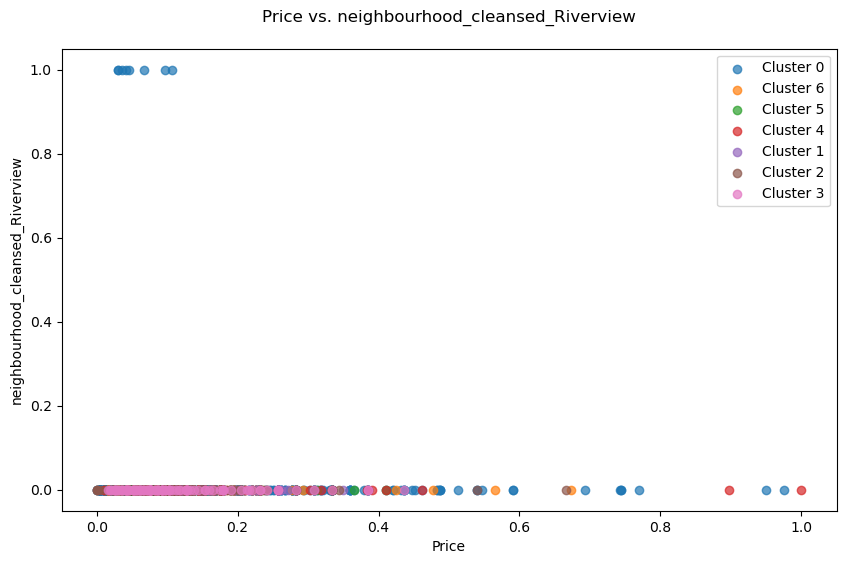

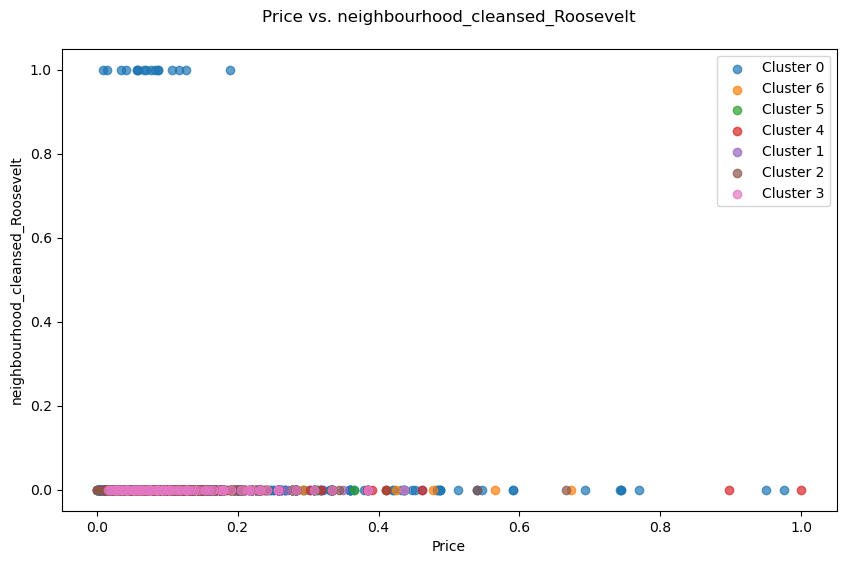

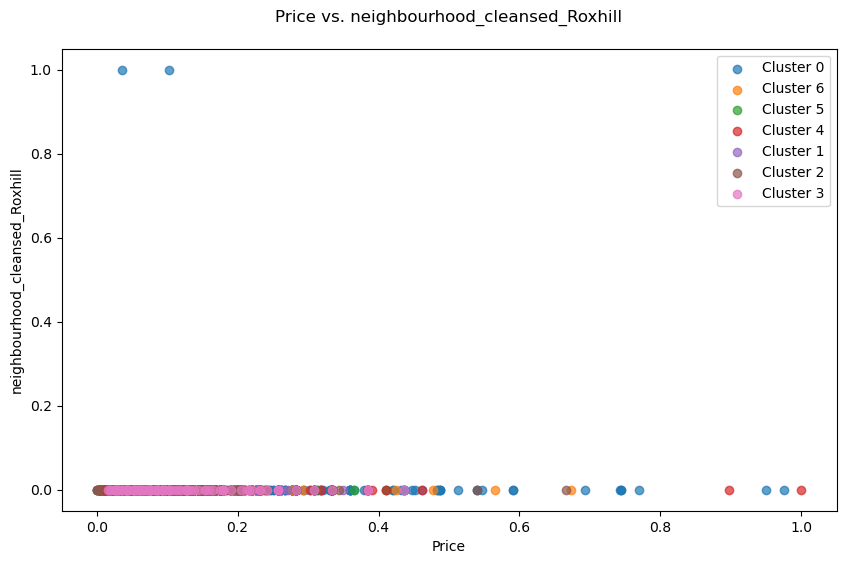

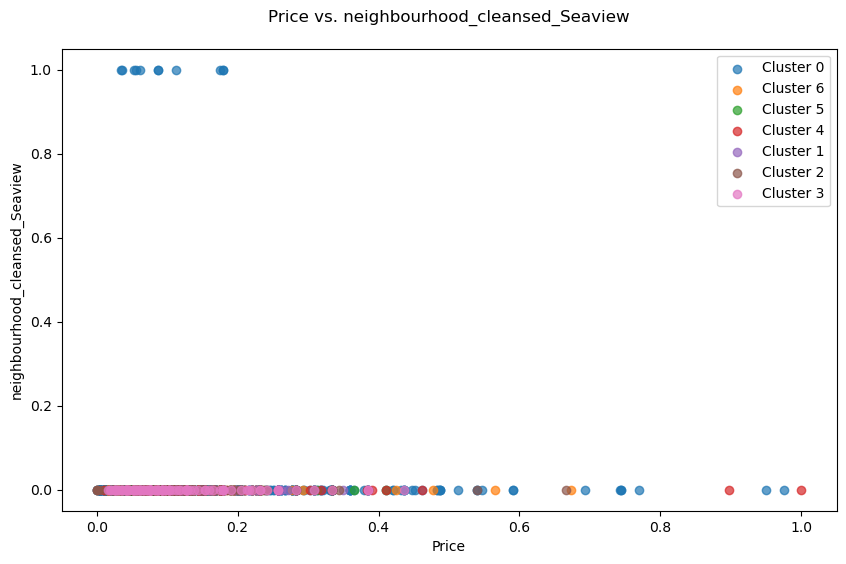

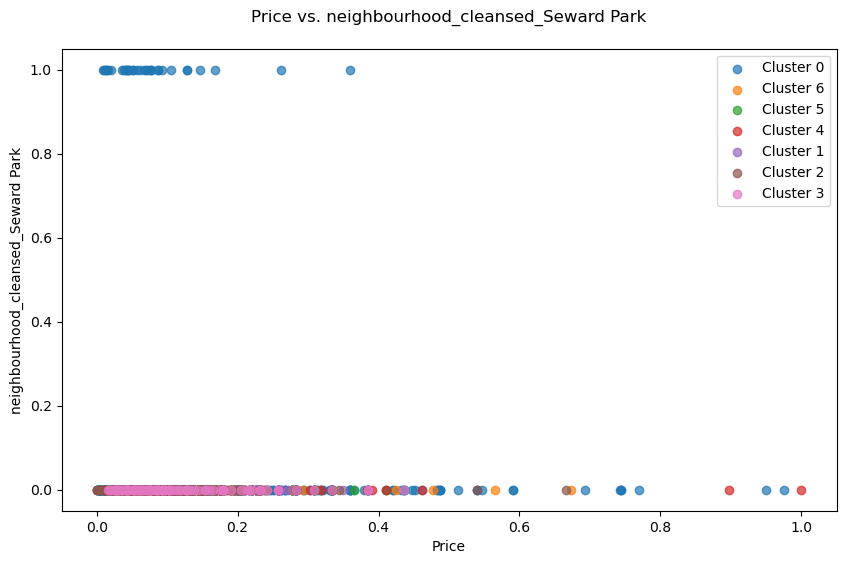

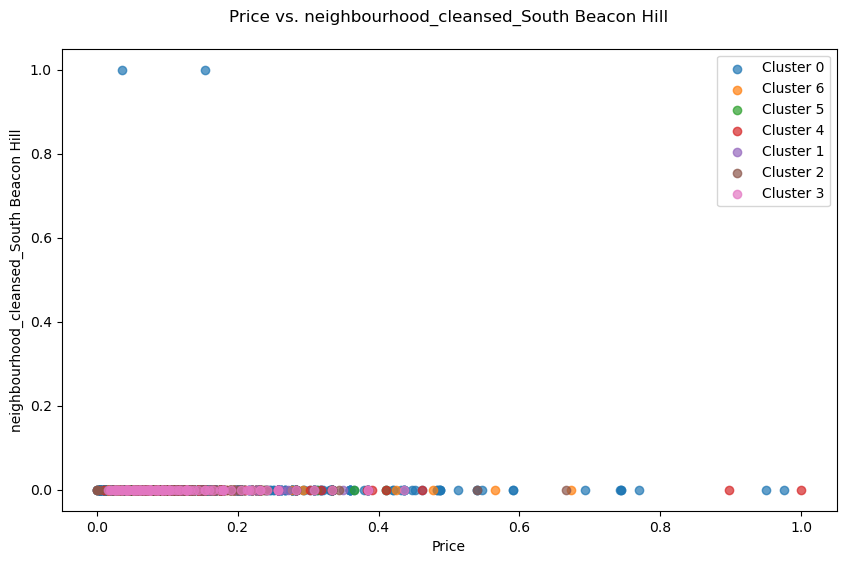

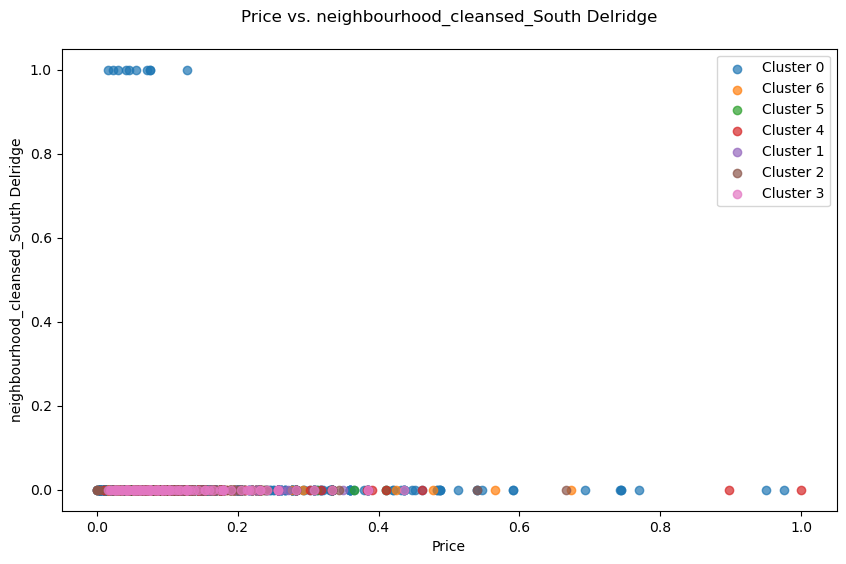

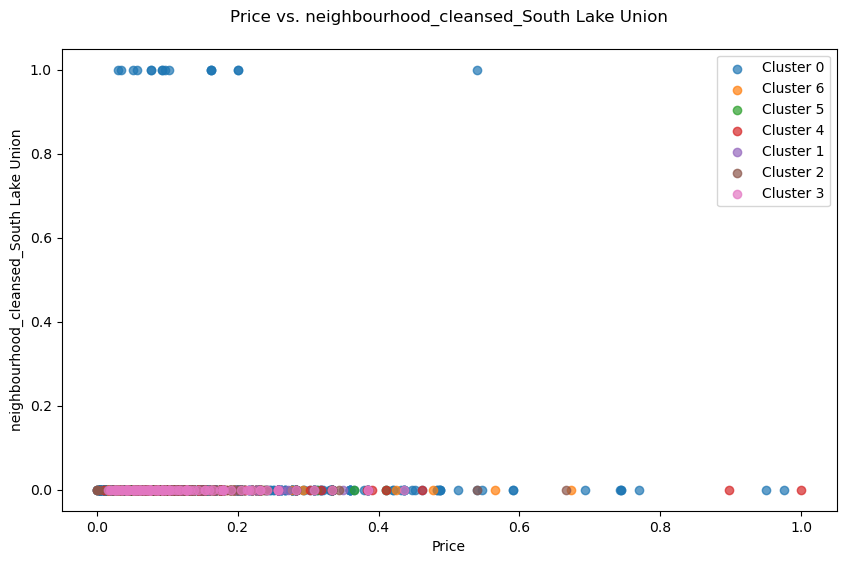

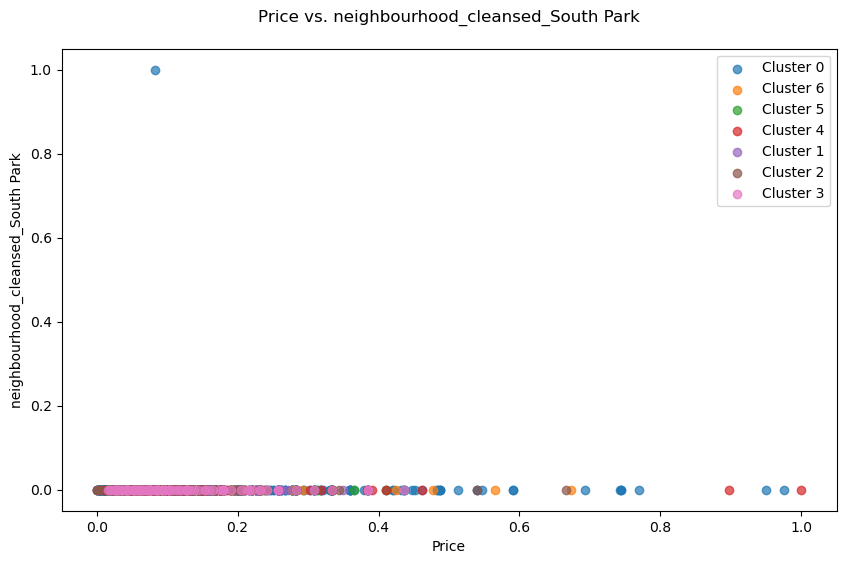

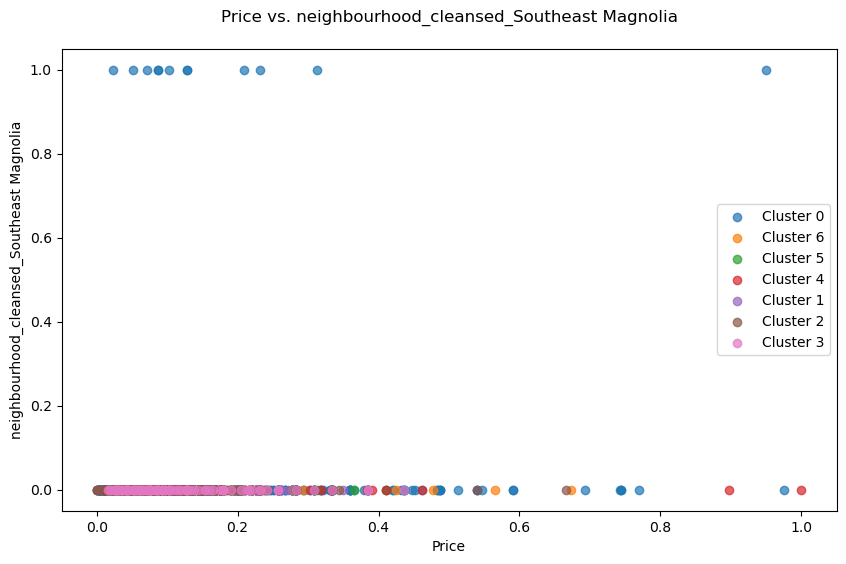

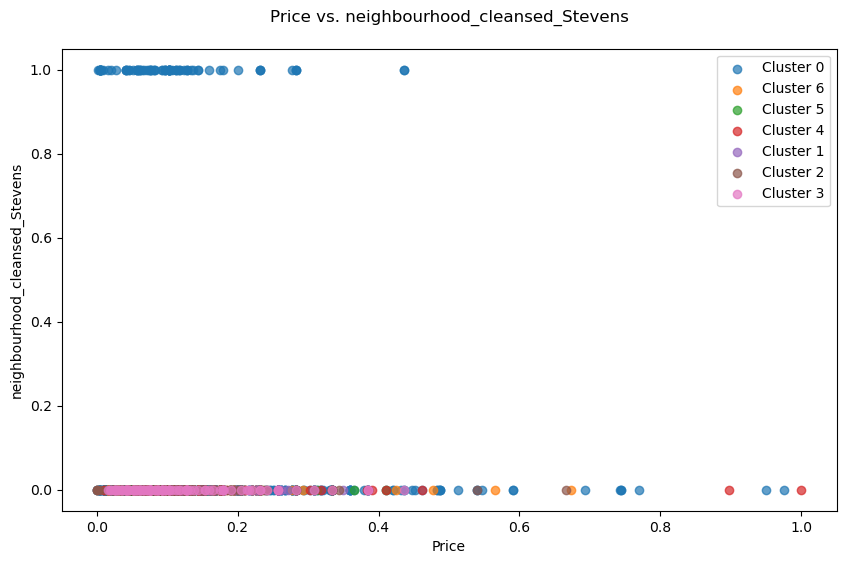

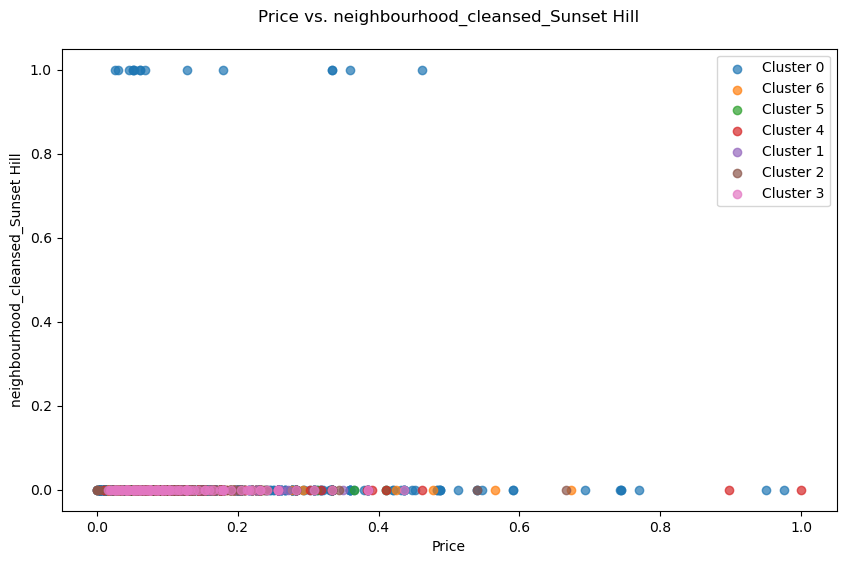

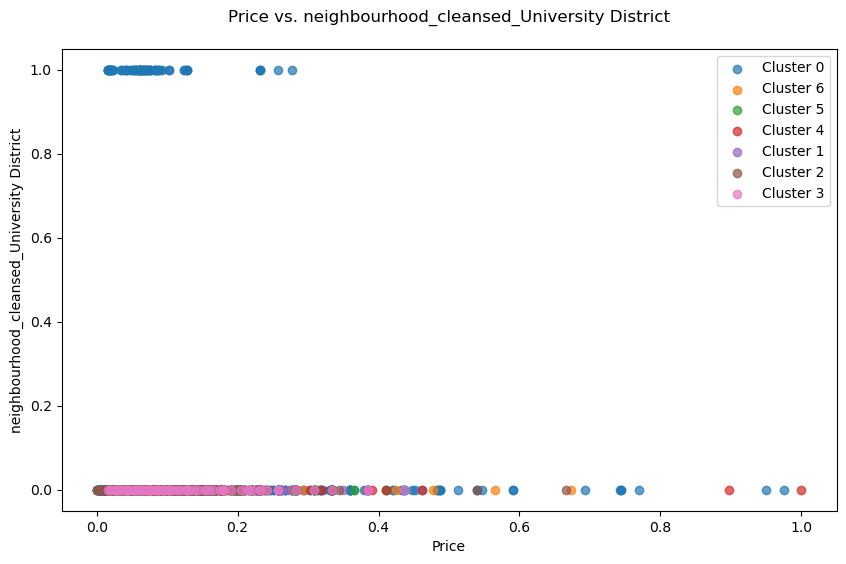

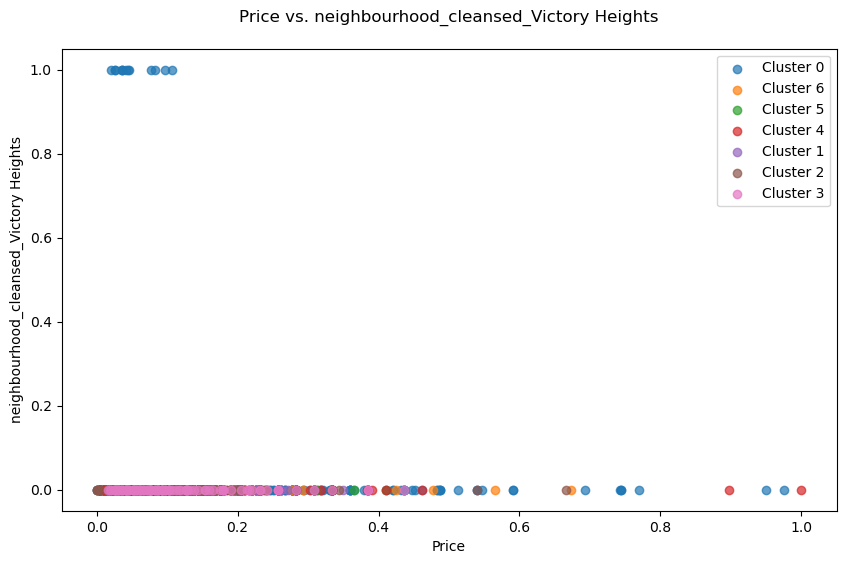

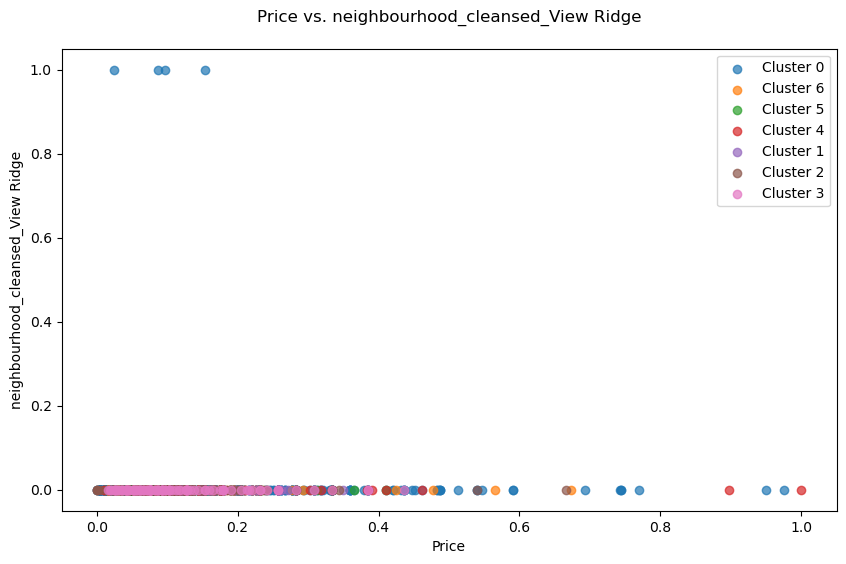

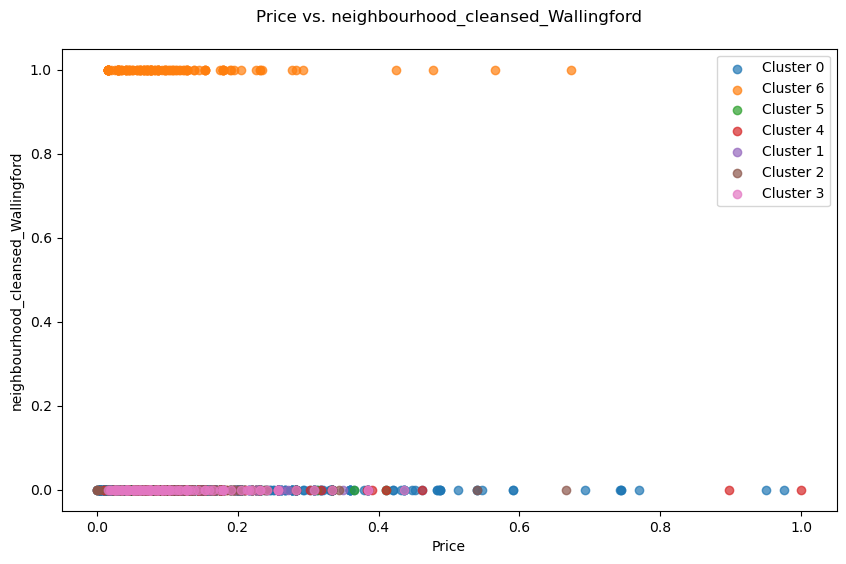

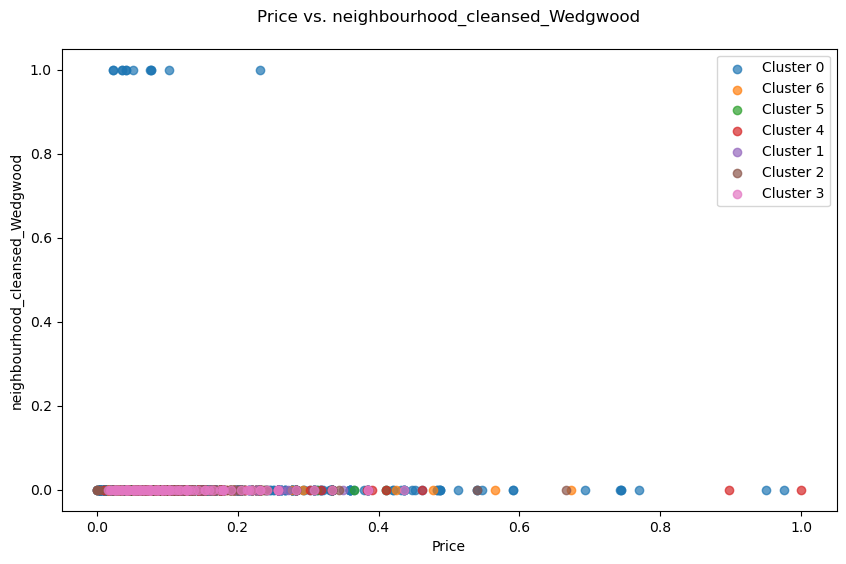

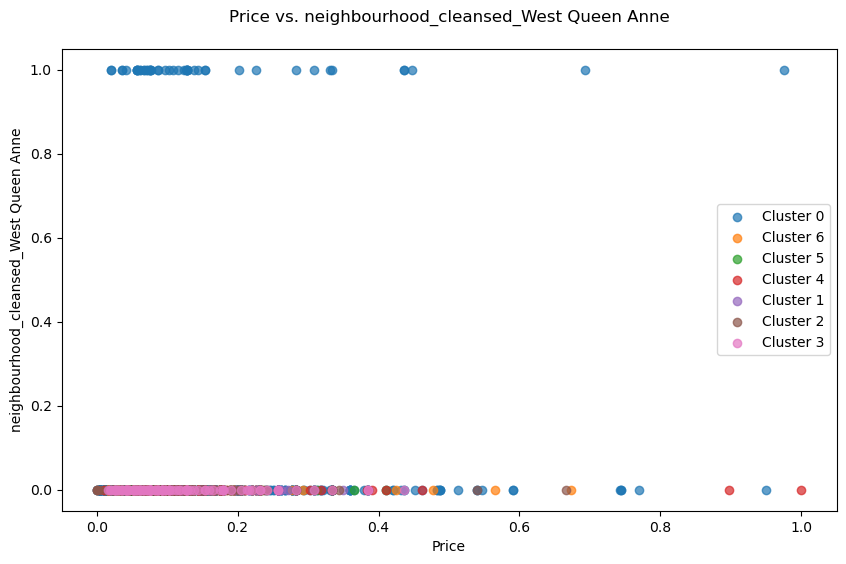

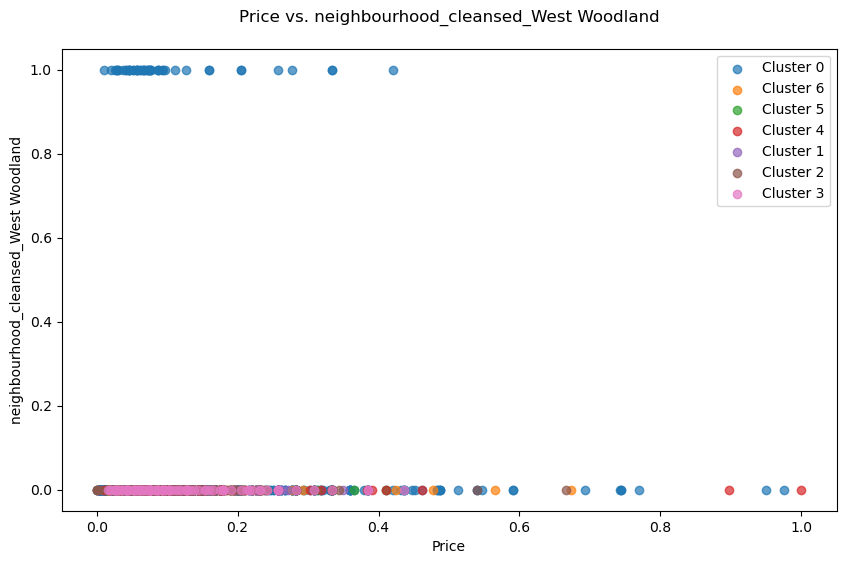

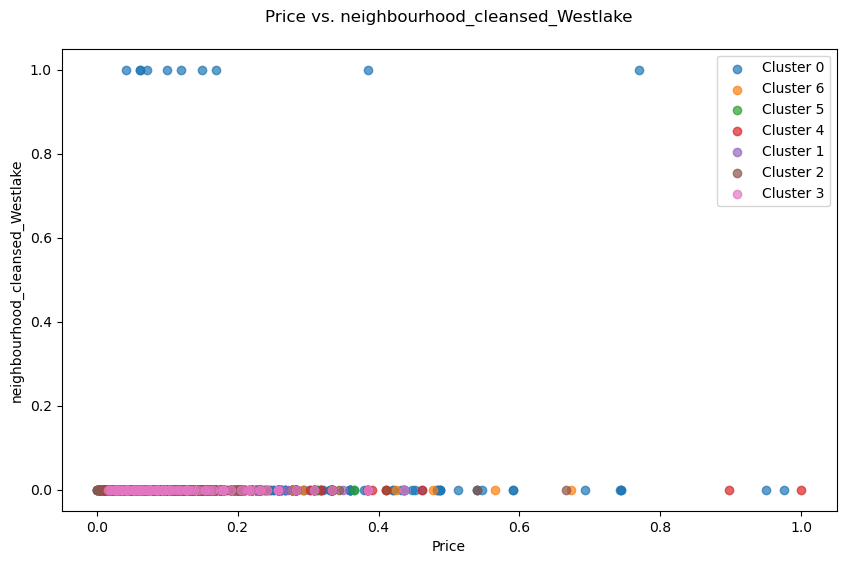

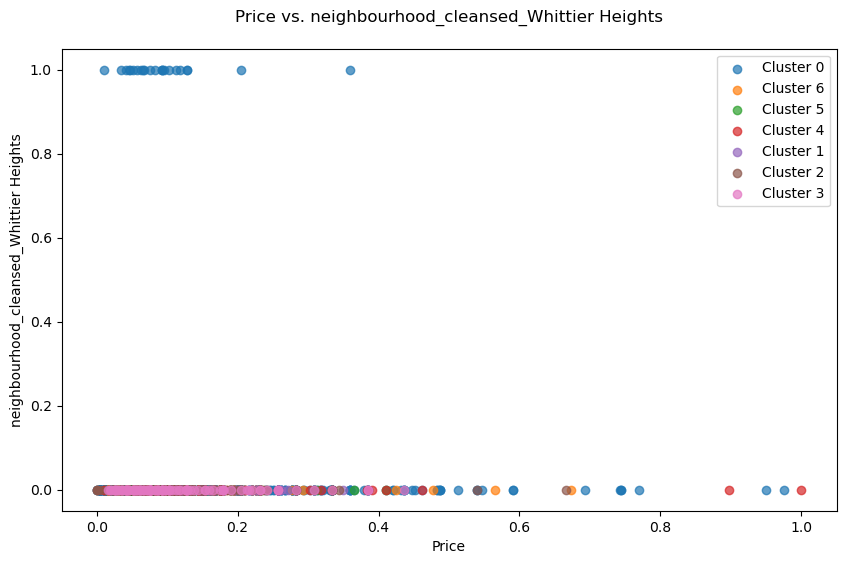

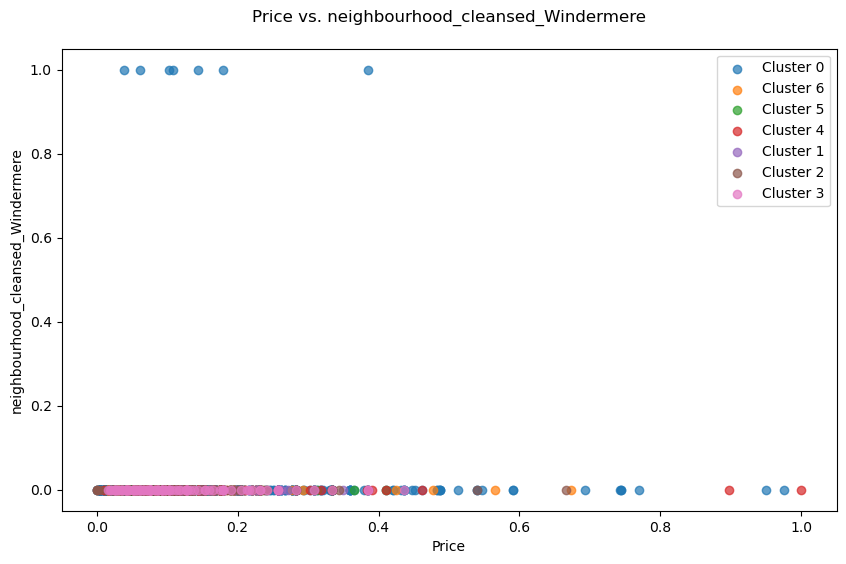

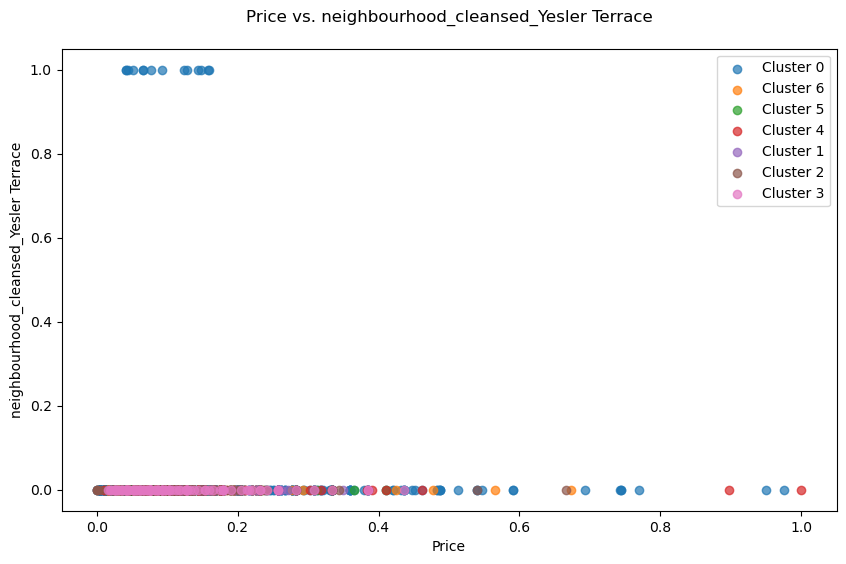

In [ ]:

dummy_columns = [col for col in df_scaled.columns if col.startswith('neighbourhood_cleansed_')]

# Iterate over each dummy variable column
for dummy_col in dummy_columns:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    for cluster in df_scaled['Cluster Number'].unique():
        cluster_data = df_scaled[df_scaled['Cluster Number'] == cluster]
        plt.scatter(cluster_data['price'], cluster_data[dummy_col], 
                    label=f'Cluster {cluster}', alpha=0.7)
    
    plt.title(f'Price vs. {dummy_col}\n')
    plt.xlabel('Price')
    plt.ylabel(f'{dummy_col}')
    plt.legend()
    plt.show()


**Inference:**

- We can see the different clusters for each neighborhood and their price values. This can help us determine approximate price ranges and estimating the prices for any potential listings that might be created
- For neighborhood "Adams", cluster 3 is widely spread across the rpice range.
- For neighborhood "Alki", cluster 3 is widely spread across the price range.
- For neighborhood Belltown, cluster 4 is widely spread but this could be due to outliers